## **Data Loading and Cleaning, Data Summary**

In [ ]:
!pip install torch-geometric
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
import torch.nn as nn
import torch_geometric.nn as pyg_nn

In [4]:
data = pd.read_csv('Salary_Data_Final.csv')

In [ ]:
data.shape

(469364, 22)

In [ ]:
data.head(5)

,salary_from,salary_to,geo_level_1_string,geo_level_2_string,geo_level_4_string,industry_level_1,industry_level_2,occupation_level_1,occupation_level_2,occupation_level_3,...,occupation_level_6,isco_code,salary_category,industry_1_name,industry_2_name,occupation_level_1_name,occupation_level_2_name,occupation_level_3_name,occupation_level_4_name,occupation_level_6_name
0,25920,32400,NL,Zuid-Holland,'S-GRAVENHAGE,C,13,23,2310,231010,...,o37y6ipobfc57ozvwgluib4kte,4120,20.000 - 35.000,Manufacturing,Vervaardiging van overige textielproducten n....,"Public Administration, Security & Justice",Judiciary,Lawyers,Lawyers,Barrister Litigator Corporate Law
1,49248,69984,NL,Gelderland,ARNHEM,C,33,15,1510,151011,...,6whiqgu7tngjpahnepi474rupe,4322,> 50.000,Manufacturing,Installatie van overige toebehoren,Creative & Linguistic,Creative & Design,Performing and visual artists,"Film, stage and related directors and producers",Technical Project Leader
2,28512,38880,NL,Zuid-Holland,BARENDRECHT,F,43,24,2411,241111,...,eulmz4idonhrbfkyw6wehuzcmd,3323,20.000 - 35.000,Construction,Overige gespecialiseerde werkzaamheden in de bouw,Sales & Marketing,Sales & Purchasing,Buyers,Buyers,Purchasing Assistant
3,25920,25920,NL,Noord-Holland,AMSTERDAM,G,46,21,2110,211013,...,vzl5v4wwufgvljeorikzfpyc3e,5131,20.000 - 35.000,Retail,Niet-gespecialiseerde groothandel,"Hospitality, Recreation & Sports",Hospitality,Waiters and Other Hospitality Workers,Food service counter attendants,Barista
4,19161,19161,NL,Gelderland,EPE,I,55,21,2111,211110,...,6gm5os5wbza2tanrmngw4jmp4f,3423,< 20.000,Hospitality,Overige logiesverstrekking,"Hospitality, Recreation & Sports",Recreation & Sports,Sports Instructors and Recreational Workers,Fitness and recreation instructors and program...,NaN


**Data Cleaning and Log-transformation**

In [5]:
data['salary_from'] = pd.to_numeric(data['salary_from'], errors='coerce')
data['salary_to']   = pd.to_numeric(data['salary_to'],   errors='coerce')

mask = (
    (data['salary_from'] > 10000) &
    (data['salary_from'] <= 1000000) &
    (data['salary_from'] <= data['salary_to']) &
    (data['salary_to'] > 10000) &
    (data['salary_to'] <= 1000000)
)

data = data[mask]


Add the Average Salary Column: (salary_from + salary_to)/2 and do the log-transformation

In [6]:
data['average'] = (data['salary_from']+ data['salary_to'])/2
data['log_average'] = np.log1p(data['average'])

In [ ]:
data.shape

(467571, 23)

In [ ]:
summary = {
    'field_name': [],
    'non_null_count': [],
    'distinct_count': []
}

for col in data.columns:
    summary['field_name'].append(col)
    summary['non_null_count'].append(data[col].notnull().sum())
    summary['distinct_count'].append(data[col].nunique(dropna=True))

df_summary = pd.DataFrame(summary)

print(df_summary)
df_summary.to_csv('field_summary.csv', index=False)


                 field_name  non_null_count  distinct_count
0               salary_from          467571            6239
1                 salary_to          467571            6727
2        geo_level_1_string          467571               1
3        geo_level_2_string          467540              12
4        geo_level_4_string          445966             408
5          industry_level_1          467571              20
6          industry_level_2          467571              83
7        occupation_level_1          467571              17
8        occupation_level_2          467571              42
9        occupation_level_3          467571             122
10       occupation_level_4          467571             347
11       occupation_level_5          467571             765
12       occupation_level_6          467571            3389
13                isco_code          467571             331
14          salary_category          461064               4
15          industry_1_name          467

## **EDA**

### **Average Salary Distribution**

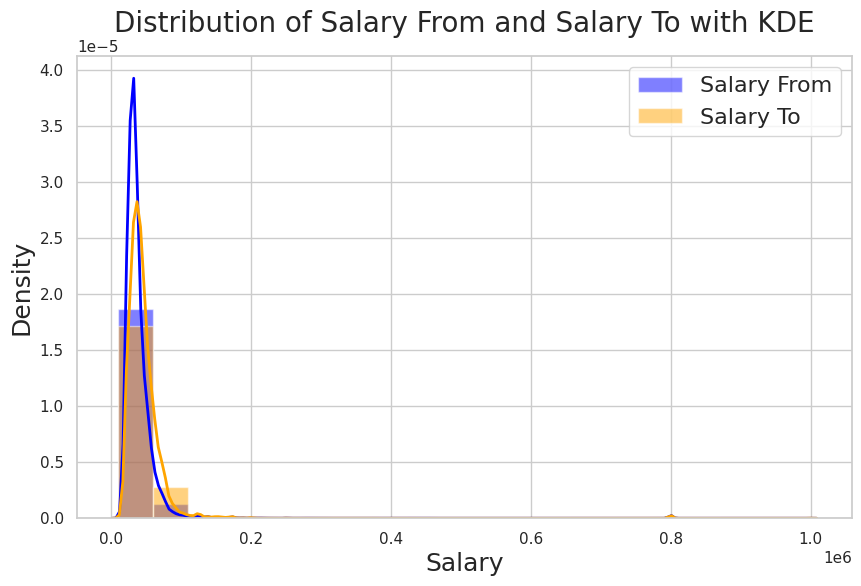

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plot the histograms with semi-transparent colors
plt.hist(data['salary_from'].dropna(), bins=20, alpha=0.5, color='blue', label='Salary From', density=True)
plt.hist(data['salary_to'].dropna(), bins=20, alpha=0.5, color='orange', label='Salary To', density=True)

# Plot the kernel density estimate (KDE) curves for both salary_from and salary_to
sns.kdeplot(data['salary_from'].dropna(), color='blue', linewidth=2)
sns.kdeplot(data['salary_to'].dropna(), color='orange', linewidth=2)

# Adding labels and title
plt.xlabel('Salary', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('Distribution of Salary From and Salary To with KDE', fontsize=20)

# Adding the legend and making it larger
plt.legend(fontsize=16)

# Show the plot
plt.show()

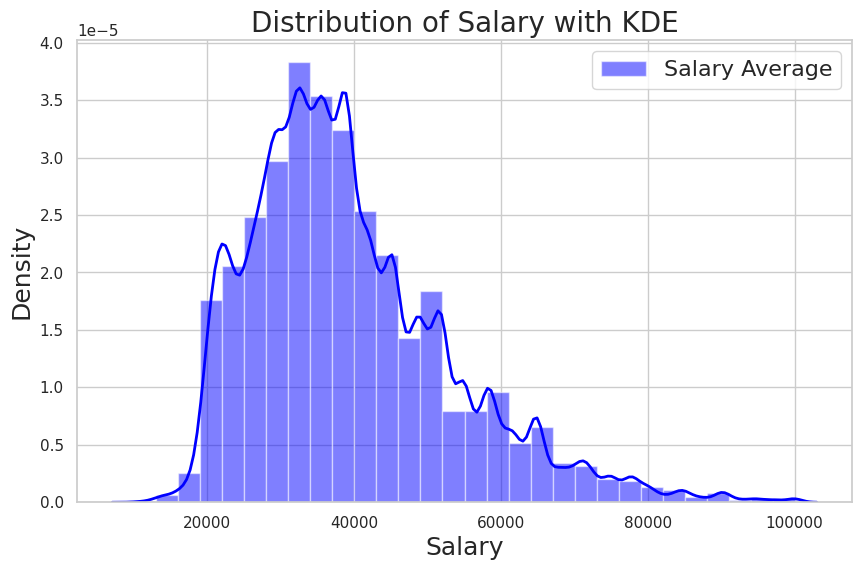

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plot the histograms with semi-transparent colors
plt.hist(data['average'], bins=30, alpha=0.5, color='blue', label='Salary Average', density=True)

# Plot the kernel density estimate (KDE) curves for both salary_from and salary_to
sns.kdeplot(data['average'], color='blue', linewidth=2)

# Adding labels and title
plt.xlabel('Salary', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('Distribution of Salary with KDE', fontsize=20)

# Adding the legend and making it larger
plt.legend(fontsize=16)

# Show the plot
plt.show()

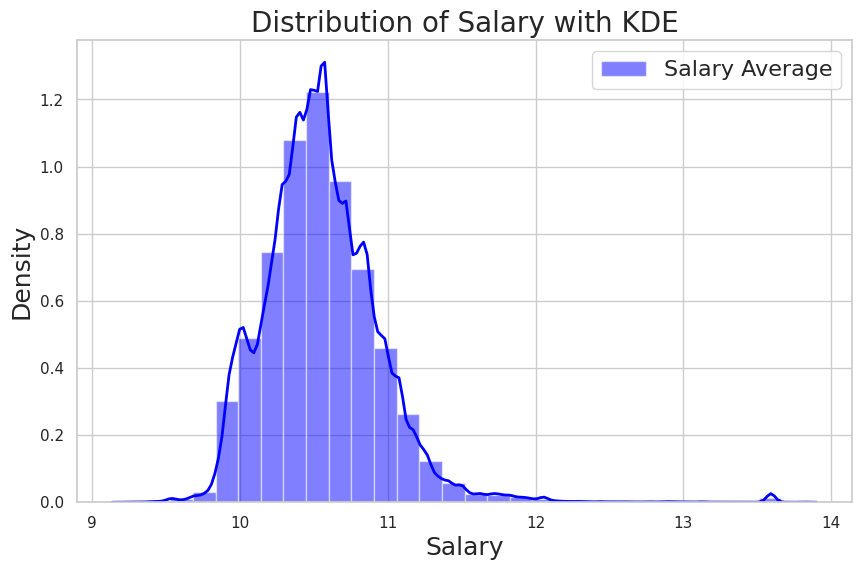

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot size and style
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plot the histograms with semi-transparent colors
plt.hist(data['log_average'], bins=30, alpha=0.5, color='blue', label='Salary Average', density=True)

# Plot the kernel density estimate (KDE) curves for both salary_from and salary_to
sns.kdeplot(data['log_average'], color='blue', linewidth=2)

# Adding labels and title
plt.xlabel('Log-Salary', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('Distribution of Log-Salary with KDE', fontsize=20)

# Adding the legend and making it larger
plt.legend(fontsize=16)

# Show the plot
plt.show()

In [ ]:
data.columns

Index(['salary_from', 'salary_to', 'geo_level_1_string', 'geo_level_2_string',
       'geo_level_4_string', 'industry_level_1', 'industry_level_2',
       'occupation_level_1', 'occupation_level_2', 'occupation_level_3',
       'occupation_level_4', 'occupation_level_5', 'occupation_level_6',
       'isco_code', 'salary_category', 'industry_1_name', 'industry_2_name',
       'occupation_level_1_name', 'occupation_level_2_name',
       'occupation_level_3_name', 'occupation_level_4_name',
       'occupation_level_6_name', 'average'],
      dtype='object')

### **Salary Grouped by Different Levels of Regions**

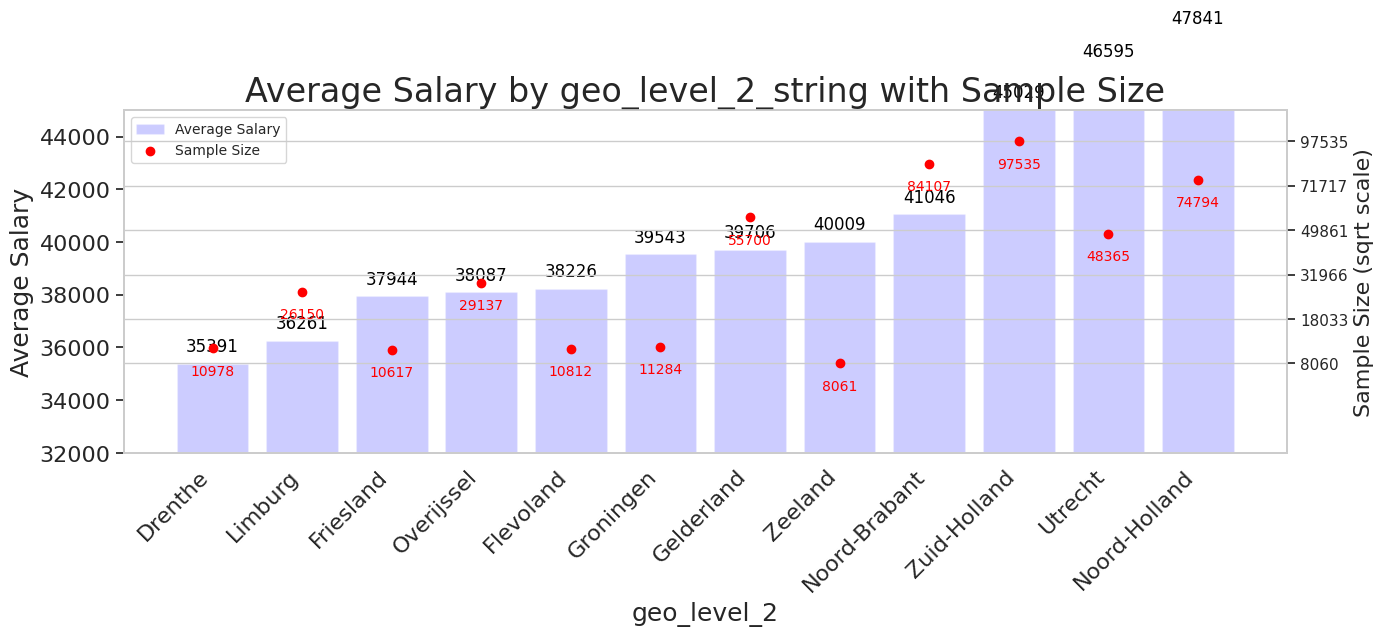

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

avg_salary_by_geo2 = data.groupby('geo_level_2_string')['average'].mean()
count_by_geo2 = data.groupby('geo_level_2_string')['average'].count()

avg_salary_by_geo2_sorted = avg_salary_by_geo2.sort_values()
count_by_geo2_sorted = count_by_geo2.loc[avg_salary_by_geo2_sorted.index]

fig, ax1 = plt.subplots(figsize=(14,7))

bars = ax1.bar(avg_salary_by_geo2_sorted.index.astype(str),
               avg_salary_by_geo2_sorted.values,
               alpha=0.2,
               label='Average Salary',
               color='blue')

ax1.set_ylabel('Average Salary', fontsize=18)
ax1.set_xlabel('geo_level_2', fontsize=18)
ax1.set_ylim(32000, 45000)
ax1.tick_params(axis='y', labelsize=16)
ax1.set_title('Average Salary by geo_level_2_string with Sample Size', fontsize=24)
ax1.grid(False)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 300, f'{height:.0f}',
             ha='center', va='bottom', fontsize=12, color='black')

ax2 = ax1.twinx()

counts = count_by_geo2_sorted.values
x = np.arange(len(avg_salary_by_geo2_sorted))
y_positions = np.sqrt(counts)

ax2.scatter(x, y_positions, color='red', label='Sample Size', zorder=5)
ax2.set_ylabel('Sample Size (sqrt scale)', fontsize=16)
ax2.set_ylim(0, y_positions.max() * 1.1)

def sqrt_tick_formatter(val, pos):
    return f'{int(val**2)}'

ticks = np.linspace(y_positions.min(), y_positions.max(), num=6)
ax2.set_yticks(ticks)
ax2.set_yticklabels([sqrt_tick_formatter(t, None) for t in ticks])

for i, (pos, count) in enumerate(zip(y_positions, counts)):
    ax2.text(i, pos - (y_positions.max() * 0.05), f'{count}', ha='center', va='top', fontsize=10, color='red')

ax1.set_xticks(x)
ax1.set_xticklabels(avg_salary_by_geo2_sorted.index.astype(str), rotation=45, ha='right', fontsize=16)

lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


<ipython-input-15-c9e8c073061b>:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(combined_avg.index.astype(str), rotation=45, ha='right')


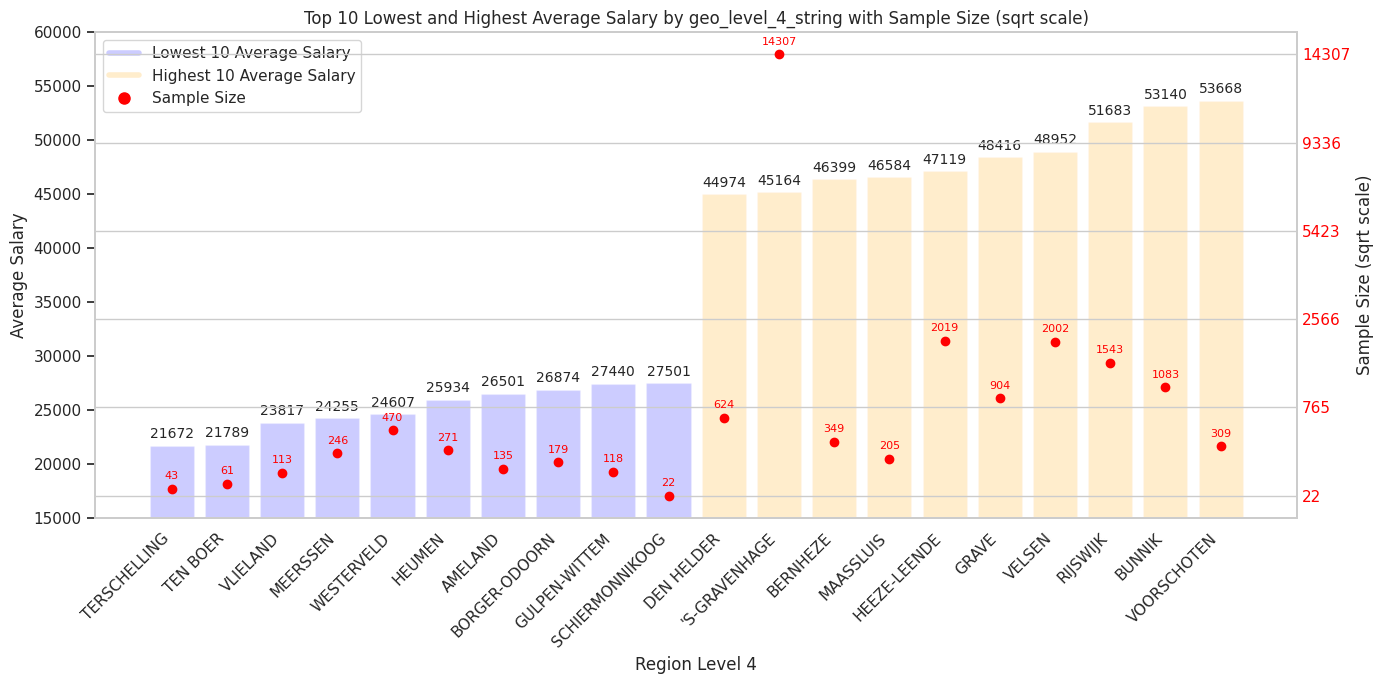

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 计算平均薪资和样本数
avg_salary_by_region_4 = data.groupby('geo_level_4_string')['average'].mean()
sample_size_by_region_4 = data.groupby('geo_level_4_string')['average'].count()

# 取最低10和最高10并排序
lowest_10 = avg_salary_by_region_4.nsmallest(10).sort_values()
highest_10 = avg_salary_by_region_4.nlargest(10).sort_values()

combined_avg = pd.concat([lowest_10, highest_10])
combined_sample = pd.concat([
    sample_size_by_region_4.loc[lowest_10.index],
    sample_size_by_region_4.loc[highest_10.index]
])

fig, ax1 = plt.subplots(figsize=(14,7))

# 取消网格
ax1.grid(False)

# 画柱状图，透明度0.2
bars = ax1.bar(combined_avg.index.astype(str),
               combined_avg.values,
               color=['blue']*10 + ['orange']*10,
               alpha=0.2,
               label='Average Salary')

ax1.set_ylabel('Average Salary')
ax1.set_xlabel('Region Level 4')
ax1.set_ylim(15000, 60000)
ax1.set_xticklabels(combined_avg.index.astype(str), rotation=45, ha='right')
ax1.set_title('Top 10 Lowest and Highest Average Salary by geo_level_4_string with Sample Size (sqrt scale)')

# 显示平均薪资数值标签（柱子顶部）
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 400, f'{height:.0f}',
             ha='center', va='bottom', fontsize=10)

# 右侧y轴画样本数量散点图，平方根缩放
ax2 = ax1.twinx()
ax2.set_ylabel('Sample Size (sqrt scale)')
counts = combined_sample.values
x = np.arange(len(combined_avg))
y_positions = np.sqrt(counts)

ax2.scatter(x, y_positions, color='red', label='Sample Size', zorder=5)

# 自定义y轴刻度显示原始样本数（平方后的数）
def sqrt_tick_formatter(x, pos):
    return f'{int(x**2)}'

ticks = np.linspace(y_positions.min(), y_positions.max(), num=6)
ax2.set_yticks(ticks)
ax2.set_yticklabels([sqrt_tick_formatter(t, None) for t in ticks])
ax2.tick_params(axis='y', colors='red')

# 不显示右侧刻度线长度
ax2.tick_params(axis='y', which='both', length=0)

# 样本数标签，稍往上偏移避免遮挡散点
for i, (pos, count) in enumerate(zip(y_positions, counts)):
    ax2.text(i, pos+2, f'{count}', ha='center', va='bottom', fontsize=8, color='red')

# 设置x轴刻度和标签
ax1.set_xticks(x)
ax1.set_xticklabels(combined_avg.index.astype(str), rotation=45, ha='right')

# 图例合并
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=4, alpha=0.2, label='Lowest 10 Average Salary'),
    Line2D([0], [0], color='orange', lw=4, alpha=0.2, label='Highest 10 Average Salary'),
    Line2D([0], [0], marker='o', color='red', label='Sample Size', lw=0, markersize=8)
]
ax1.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()




### **Salary Grouped by Different Levels of Industries**

<ipython-input-16-61b1a05e959f>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(avg_salary_by_industry_1_sorted.index.astype(str), rotation=45, ha='right')


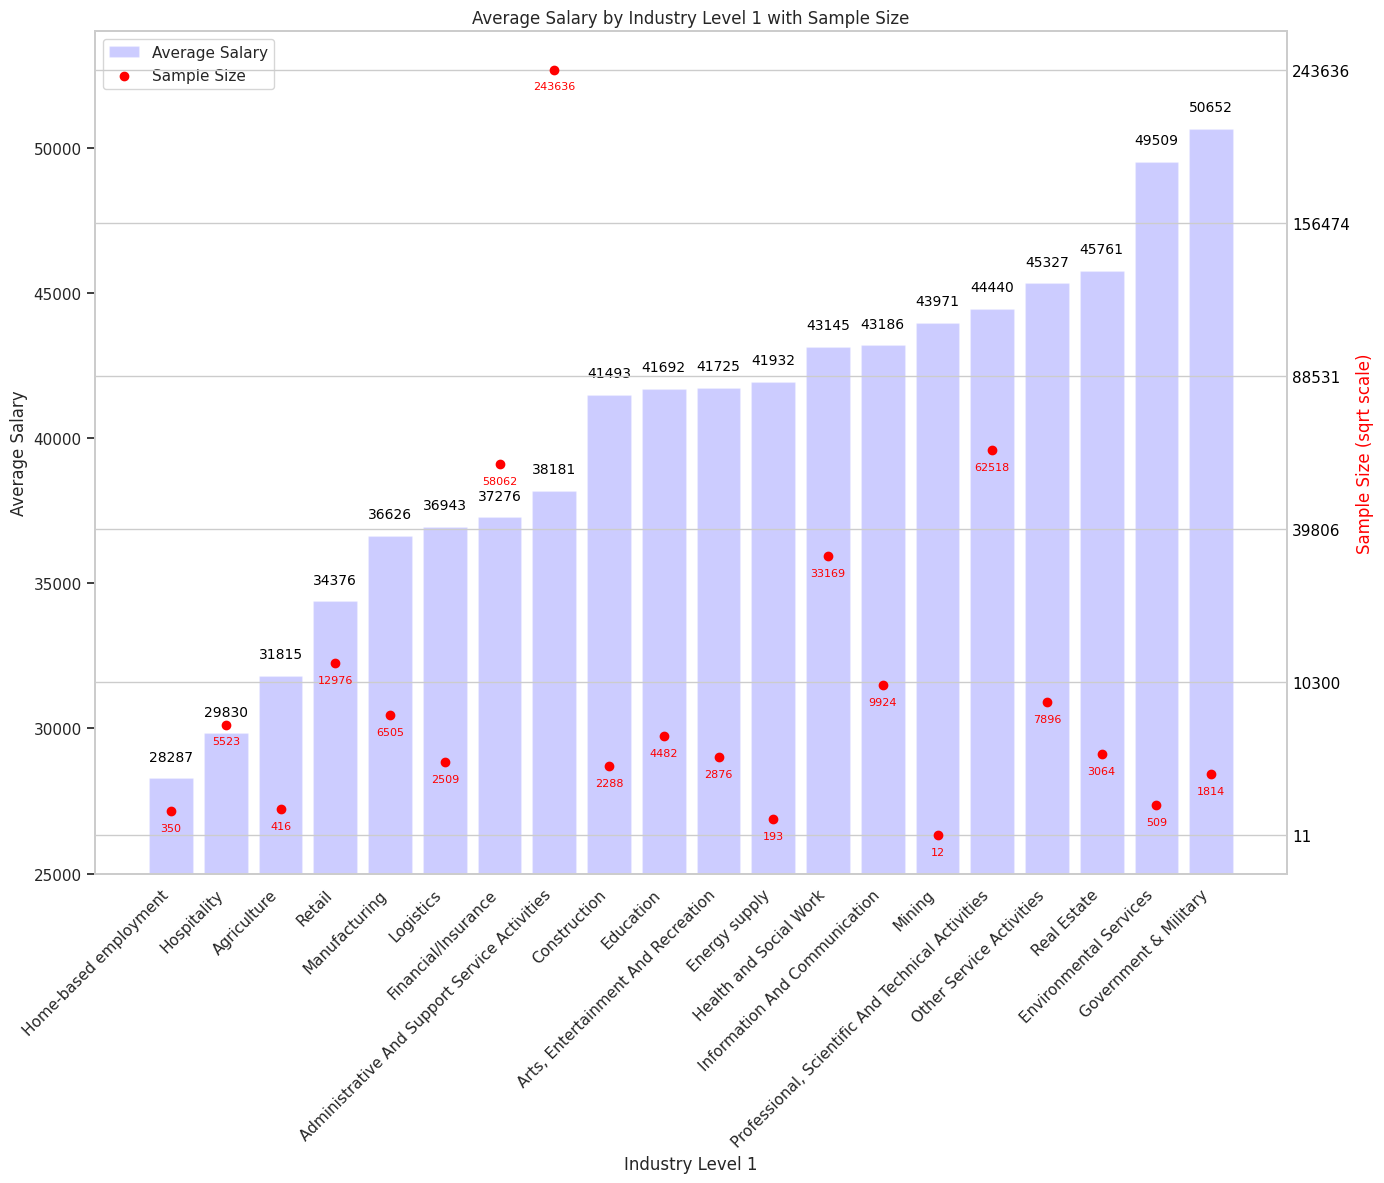

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

avg_salary_by_industry_1 = data.groupby('industry_1_name')['average'].mean()
count_by_industry_1 = data.groupby('industry_1_name')['average'].count()

# 排序保持一致
avg_salary_by_industry_1_sorted = avg_salary_by_industry_1.sort_values()
count_by_industry_1_sorted = count_by_industry_1.loc[avg_salary_by_industry_1_sorted.index]

fig, ax1 = plt.subplots(figsize=(14,12))

# 画柱状图（平均薪资），透明度设为0.2
bars = ax1.bar(avg_salary_by_industry_1_sorted.index.astype(str),
               avg_salary_by_industry_1_sorted.values,
               alpha=0.2,
               label='Average Salary',
               color='blue')

ax1.set_ylabel('Average Salary')
ax1.set_xlabel('Industry Level 1')
ax1.set_ylim(25000, 54000)
ax1.set_xticklabels(avg_salary_by_industry_1_sorted.index.astype(str), rotation=45, ha='right')
ax1.set_title('Average Salary by Industry Level 1 with Sample Size')

# 取消网格
ax1.grid(False)

# 添加平均薪资标签，稍微往上偏移，避免和样本数标签重叠
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 500, f'{height:.0f}',
             ha='center', va='bottom', fontsize=10, color='black')

# 创建第二个y轴，画样本数，用平方根缩放
ax2 = ax1.twinx()
ax2.set_ylabel('Sample Size (sqrt scale)', color='red')

counts = count_by_industry_1_sorted.values
x = np.arange(len(avg_salary_by_industry_1_sorted))
y_positions = np.sqrt(counts)

ax2.scatter(x, y_positions, color='red', label='Sample Size', zorder=5)

# 自定义y轴刻度显示原始样本数（平方后）
def sqrt_tick_formatter(x, pos):
    return f'{int(x**2)}'

# 生成合适的刻度（取平方根后，均匀分布）
ticks = np.linspace(y_positions.min(), y_positions.max(), num=6)
ax2.set_yticks(ticks)
ax2.set_yticklabels([sqrt_tick_formatter(t, None) for t in ticks])
ax2.tick_params(axis='y', colors='black')

# 不显示右侧y轴刻度线
ax2.tick_params(axis='y', which='both', length=0)

# 样本数标签，稍往上偏移避免遮挡散点
for i, (pos, count) in enumerate(zip(y_positions, counts)):
    ax2.text(i, pos-14, f'{count}', ha='center', va='bottom', fontsize=8, color='red')

# 设置x轴刻度和标签
ax1.set_xticks(x)
ax1.set_xticklabels(avg_salary_by_industry_1_sorted.index.astype(str), rotation=45, ha='right')

# 图例合并显示
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.show()

**Top 10 Lowest and Highest Average Salary by Industry Level 2**

<ipython-input-17-5553421ba755>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(combined_avg.index.astype(str), rotation=45, ha='right')


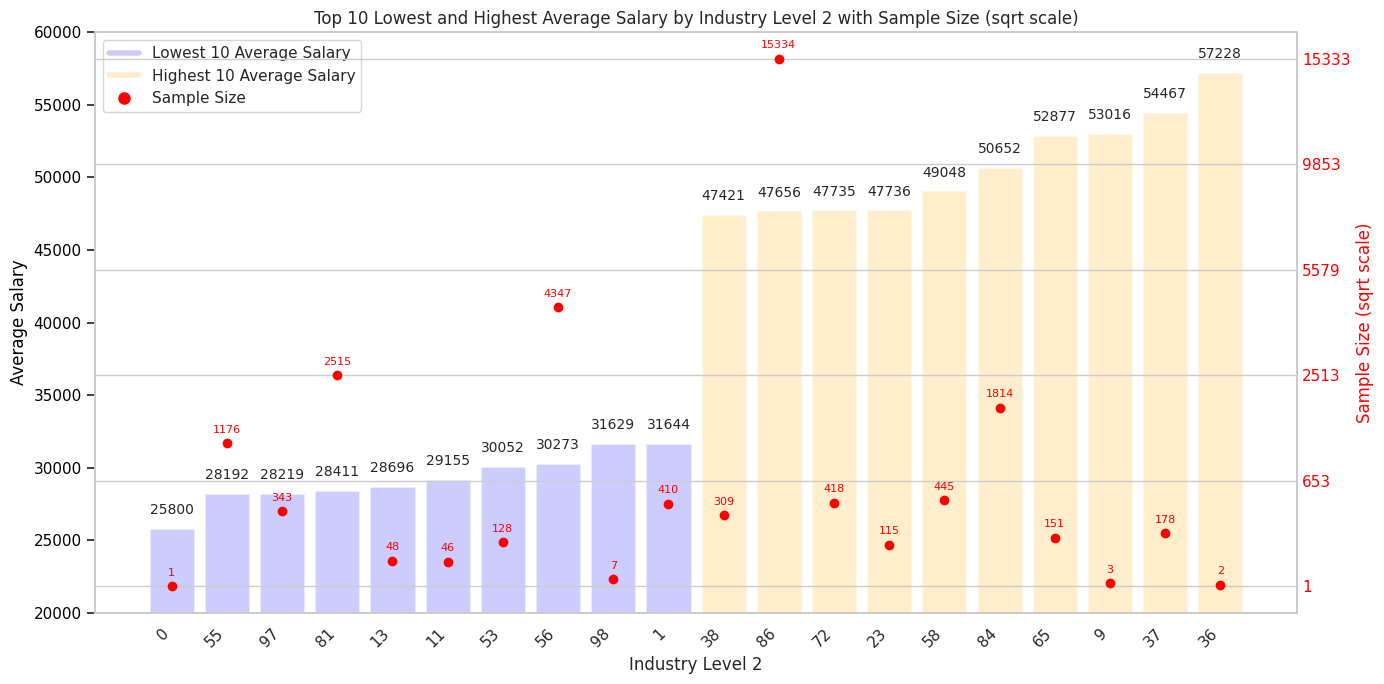

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

avg_salary = data.groupby('industry_level_2')['average'].mean()
count_data = data.groupby('industry_level_2')['average'].count()

lowest_10 = avg_salary.nsmallest(10).sort_values()
highest_10 = avg_salary.nlargest(10).sort_values()
combined_avg = pd.concat([lowest_10, highest_10])
combined_count = count_data.loc[combined_avg.index]

fig, ax1 = plt.subplots(figsize=(14,7))

ax1.grid(False)

colors = ['blue']*10 + ['orange']*10
bars = ax1.bar(combined_avg.index.astype(str), combined_avg.values, color=colors, alpha=0.2)
ax1.set_xlabel('Industry Level 2')
ax1.set_ylabel('Average Salary', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(20000, 60000)
ax1.set_xticklabels(combined_avg.index.astype(str), rotation=45, ha='right')
ax1.set_title('Top 10 Lowest and Highest Average Salary by Industry Level 2 with Sample Size (sqrt scale)')

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 800, f'{height:.0f}',
             ha='center', va='bottom', fontsize=10)

ax2 = ax1.twinx()
ax2.set_ylabel('Sample Size (sqrt scale)', color='red')

counts = combined_count.values
x = np.arange(len(combined_avg))
y_positions = np.sqrt(counts)

ax2.scatter(x, y_positions, color='red', label='Sample Size', zorder=5)

def sqrt_tick_formatter(x, pos):
    return f'{int(x**2)}'

ticks = np.linspace(y_positions.min(), y_positions.max(), num=6)
ax2.set_yticks(ticks)
ax2.set_yticklabels([sqrt_tick_formatter(t, None) for t in ticks])
ax2.tick_params(axis='y', colors='red')
ax2.tick_params(axis='y', which='both', length=0)

for i, (pos, count) in enumerate(zip(y_positions, counts)):
    ax2.text(i, pos+2, f'{count}', ha='center', va='bottom', fontsize=8, color='red')

ax1.set_xticks(x)
ax1.set_xticklabels(combined_avg.index.astype(str), rotation=45, ha='right')

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=4, alpha=0.2, label='Lowest 10 Average Salary'),
    Line2D([0], [0], color='orange', lw=4, alpha=0.2, label='Highest 10 Average Salary'),
    Line2D([0], [0], marker='o', color='red', label='Sample Size', lw=0, markersize=8)
]
ax1.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()




### **Salary Grouped by Different Levels of Occupations**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

avg_salary_by_occ1 = data.groupby('occupation_level_1_name')['average'].mean()
count_by_occ1 = data.groupby('occupation_level_1_name')['average'].count()

avg_salary_by_occ1_sorted = avg_salary_by_occ1.sort_values()
count_by_occ1_sorted = count_by_occ1.loc[avg_salary_by_occ1_sorted.index]

fig, ax1 = plt.subplots(figsize=(14,7))

bars = ax1.bar(avg_salary_by_occ1_sorted.index.astype(str),
               avg_salary_by_occ1_sorted.values,
               alpha=0.2,
               label='Average Salary',
               color='blue')

ax1.set_ylabel('Average Salary', fontsize=10)
ax1.set_xlabel('Occupation Level 1', fontsize=10)
ax1.set_ylim(22000, 52000)
ax1.set_xticklabels(avg_salary_by_occ1_sorted.index.astype(str), rotation=45, ha='right', fontsize=8)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_title('Average Salary by Occupation Level 1 with Sample Size', fontsize=16)

ax1.grid(False)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 500, f'{height:.0f}',
             ha='center', va='bottom', fontsize=12, color='black')

ax2 = ax1.twinx()
ax2.set_ylabel('Sample Size (sqrt scale)', fontsize=10)
ax2.tick_params(axis='y', labelsize=8)

counts = count_by_occ1_sorted.values
x = np.arange(len(avg_salary_by_occ1_sorted))
y_positions = np.sqrt(counts)

ax2.scatter(x, y_positions, color='red', label='Sample Size', zorder=5)

def sqrt_tick_formatter(x, pos):
    return f'{int(x**2)}'

ticks = np.linspace(y_positions.min(), y_positions.max(), num=6)
ax2.set_ylim(0, y_positions.max()*1.1)  # y轴从0开始
ax2.set_yticks(ticks)
ax2.set_yticklabels([sqrt_tick_formatter(t, None) for t in ticks])

for i, (pos, count) in enumerate(zip(y_positions, counts)):
    ax2.text(i, pos*1.05, f'{count}', ha='center', va='bottom', fontsize=10, color='red')

ax1.set_xticks(x)
ax1.set_xticklabels(avg_salary_by_occ1_sorted.index.astype(str), rotation=45, ha='right', fontsize=8)

lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

avg_salary_by_occ6 = data.groupby('occupation_level_6_name')['average'].mean()
count_by_occ6 = data.groupby('occupation_level_6')['average'].count()

lowest_10 = avg_salary_by_occ6.nsmallest(10).sort_values()
highest_10 = avg_salary_by_occ6.nlargest(10).sort_values()

combined_avg = pd.concat([lowest_10, highest_10])
combined_count = count_by_occ6.loc[combined_avg.index]

fig, ax1 = plt.subplots(figsize=(14,7))

colors = ['blue']*10 + ['orange']*10
bars = ax1.bar(combined_avg.index.astype(str), combined_avg.values, color=colors, alpha=0.2)
ax1.set_xlabel('Occupation Level 6')
ax1.set_ylabel('Average Salary', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(20000, 100000)
ax1.set_xticklabels(combined_avg.index.astype(str), rotation=45, ha='right', fontsize=8)
ax1.set_title('Top 10 Lowest and Highest Average Salary by Occupation Level 6 with Sample Size')

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 800, f'{height:.0f}',
             ha='center', va='bottom', fontsize=10, color='black')

ax2 = ax1.twinx()
ax2.set_ylabel('Sample Size (sqrt scale)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

counts = combined_count.values
x = np.arange(len(combined_avg))
y_positions = np.sqrt(counts)

ax2.scatter(x, y_positions, color='red', label='Sample Size', zorder=5)

# 自定义y轴刻度显示原始样本数（平方后）
def sqrt_tick_formatter(x, pos):
    return f'{int(x**2)}'

ticks = np.linspace(y_positions.min(), y_positions.max(), num=6)
ax2.set_ylim(0, y_positions.max()*1.1)  # y轴从0开始
ax2.set_yticks(ticks)
ax2.set_yticklabels([sqrt_tick_formatter(t, None) for t in ticks])

# 样本数标签，稍往上偏移避免遮挡散点
for i, (pos, count) in enumerate(zip(y_positions, counts)):
    ax2.text(i, pos*1.05, f'{count}', ha='center', va='bottom', fontsize=10, color='red')

# 设置x轴刻度和标签
ax1.set_xticks(x)
ax1.set_xticklabels(combined_avg.index.astype(str), rotation=45, ha='right', fontsize=8)

# 图例合并显示
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


## **Creating Graphs for Each Feature**

In [7]:
from time import time
start_time_region = time()
G_region = nx.Graph()
node_mapping_region = {}
node_index_region = {}

print("Processing Region Graph...")
for index, row in data.iterrows():
    geo_l2_node = row['geo_level_2_string']
    geo_l4_node = row['geo_level_4_string']

    # Add geo_level_2_node
    if pd.notna(geo_l2_node) and geo_l2_node not in node_mapping_region:
        node_mapping_region[geo_l2_node] = node_index_region
        G_region.add_node(geo_l2_node, type='geo_level_2', id=node_index_region)
        node_index_region += 1

    # Add geo_level_4_node
    if pd.notna(geo_l4_node) and geo_l4_node not in node_mapping_region:
        node_mapping_region[geo_l4_node] = node_index_region
        G_region.add_node(geo_l4_node, type='geo_level_4', id=node_index_region)
        node_index_region += 1

    # Add edge between geo_level_2 and geo_level_4 if both exist
    if pd.notna(geo_l2_node) and pd.notna(geo_l4_node):
        G_region.add_edge(geo_l2_node, geo_l4_node)
end_time_region = time()
print(f"Region Graph built in {end_time_region-start_time_region:.4f} seconds.")

# --- Occupation Graph ---
start_time_occupation = time()
G_occupation = nx.Graph()
node_mapping_occupation = {}
node_index_occ = 0

print("\nProcessing Occupation Graph...")
for index, row in data.iterrows():
    occ_l1_node = row['occupation_level_1_name']
    occ_l2_node = row['occupation_level_2_name']
    occ_l6_node = row['occupation_level_6_name']

    if pd.notna(occ_l1_node) and occ_l1_node not in node_mapping_occupation:
        node_mapping_occupation[occ_l1_node] = node_index_occ
        G_occupation.add_node(occ_l1_node, type='occupation_level_1', id=node_index_occ)
        node_index_occ += 1

    if pd.notna(occ_l2_node) and occ_l2_node not in node_mapping_occupation:
        node_mapping_occupation[occ_l2_node] = node_index_occ
        G_occupation.add_node(occ_l2_node, type='occupation_level_2', id=node_index_occ)
        node_index_occ += 1

    if pd.notna(occ_l6_node) and occ_l6_node not in node_mapping_occupation:
        node_mapping_occupation[occ_l6_node] = node_index_occ
        G_occupation.add_node(occ_l6_node, type='occupation_level_6', id=node_index_occ)
        node_index_occ += 1

    if pd.notna(occ_l1_node) and pd.notna(occ_l2_node):
        G_occupation.add_edge(occ_l1_node, occ_l2_node)
    if pd.notna(occ_l2_node) and pd.notna(occ_l6_node):
        G_occupation.add_edge(occ_l2_node, occ_l6_node)
end_time_occupation = time()
print(f"Occupation Graph built in {end_time_occupation-start_time_occupation:.4f} seconds.")


# --- Industry Graph ---
start_time_industry = time()
G_industry = nx.Graph()
node_mapping_industry = {}
node_index_ind = 0

print("\nProcessing Industry Graph...")
for index, row in data.iterrows():
    ind_l1_node_name = row['industry_1_name']
    ind_l2_node_name = row['industry_2_name']

    # Add industry_1_name node
    if pd.notna(ind_l1_node_name) and ind_l1_node_name not in node_mapping_industry:
        node_mapping_industry[ind_l1_node_name] = node_index_ind
        G_industry.add_node(ind_l1_node_name, type='industry_level_1', id=node_index_ind)
        node_index_ind += 1

    # Add industry_2_name node
    if pd.notna(ind_l2_node_name) and ind_l2_node_name not in node_mapping_industry:
        node_mapping_industry[ind_l2_node_name] = node_index_ind
        G_industry.add_node(ind_l2_node_name, type='industry_level_2', id=node_index_ind)
        node_index_ind += 1

    # Add edge between industry_1_name and industry_2_name if both exist in the row
    if pd.notna(ind_l1_node_name) and pd.notna(ind_l2_node_name):
        # Ensure nodes are actually in the graph before adding an edge
        # This check is somewhat redundant if using the "add if not in mapping" logic above,
        # but good for robustness if node addition logic changes.
        if ind_l1_node_name in G_industry and ind_l2_node_name in G_industry:
            G_industry.add_edge(ind_l1_node_name, ind_l2_node_name)

print(f"Industry Graph: Nodes={G_industry.number_of_nodes()}, Edges={G_industry.number_of_edges()}")

# --- Create edge_index for PyTorch Geometric (if needed) ---
# This part should come AFTER the graph (G_industry) is fully constructed.
edges_industry_list = []
for u, v in G_industry.edges(): # Use G_industry.edges() directly
    if u in node_mapping_industry and v in node_mapping_industry:
        edges_industry_list.append([node_mapping_industry[u], node_mapping_industry[v]])
    # else: # Optional: handle cases where a node in an edge might not be in the mapping (shouldn't happen with this logic)
    # print(f"Warning: Node {u} or {v} not in node_mapping_industry for an edge.")

if edges_industry_list:
    edge_index_industry = torch.tensor(edges_industry_list, dtype=torch.long).t().contiguous()
else:
    edge_index_industry = torch.empty((2, 0), dtype=torch.long) # Standard for no edges in PyG



# --- Node Features (Example: One-hot encoding) ---
# The line `node_features_industry = torch.eye(25)` was problematic because 25 was arbitrary.
# The number of features should match the number of unique nodes in G_industry if using one-hot.
num_nodes_industry = len(node_mapping_industry)
node_features_industry = torch.eye(num_nodes_industry, dtype=torch.float)

print(f"\nRegion Graph: Nodes={G_region.number_of_nodes()}, Edges={G_region.number_of_edges()}")
print(f"\nOccupation Graph: Nodes={G_occupation.number_of_nodes()}, Edges={G_occupation.number_of_edges()}")
print(f"\nIndustry Graph: Nodes={G_industry.number_of_nodes()}, Edges={G_industry.number_of_edges()}")
end_time_industry = time()
print(f"Industry Graph built in {end_time_industry-start_time_industry:.4f} seconds.")

Processing Region Graph...
Region Graph built in 20.8031 seconds.

Processing Occupation Graph...
Occupation Graph built in 22.6134 seconds.

Processing Industry Graph...
Industry Graph: Nodes=103, Edges=83

Region Graph: Nodes=420, Edges=409

Occupation Graph: Nodes=2844, Edges=2831

Industry Graph: Nodes=103, Edges=83
Industry Graph built in 22.0516 seconds.


### **Edge Index Creation**

In [ ]:
edges = list(G_region.edges)
edges_index = [[node_mapping_region[node1], node_mapping_region[node2]] for node1, node2 in edges]
edge_region_index = torch.tensor(edges_index, dtype=torch.long).t().contiguous()

edges2 = list(G_occupation.edges)
edges2_index = [[node_mapping_occupation[node1], node_mapping_occupation[node2]] for node1, node2 in edges2]
edge_occupation_index = torch.tensor(edges2_index, dtype=torch.long).t().contiguous()

edges3 = list(G_industry.edges)
edges3_index = [[node_mapping_industry[node1], node_mapping_industry[node2]] for node1, node2 in edges3]
edge_industry_index = torch.tensor(edges3_index, dtype=torch.long).t().contiguous()

print(edge_region_index,edge_occupation_index,edge_industry_index)
print(len(edges_index),len(edges2_index),len(edges3_index))

In [ ]:
node_mapping_region, node_mapping_occupation, node_mapping_industry

In [ ]:
len(node_mapping_region),len(node_mapping_occupation),len(node_mapping_industry)

(420, 2844, 103)

### **Create Data objects for using in GNN**

创建一个PyTorch Geometric的Data对象，打包节点信息和边的特征，方便GNN统一处理

Create a PyTorch Geometric Data object to package node information and edge features for unified processing by GNN

In [9]:
region_data = Data(x=node_mapping_region, edge_index=edge_region_index)
occupation_data = Data(x=node_mapping_occupation, edge_index=edge_occupation_index)
industry_data = Data(x=node_mapping_industry, edge_index=edge_industry_index)

## **Graph Convolutional Network**
Define and initialize the core building blocks of Graph Convolutional Networks (GCNs) for learning feature representations of nodes from different types of attribute graphs.


In [10]:
initial_feature_dim_region = num_nodes_region = len(node_mapping_region)  # Total number of nodes in the region graph (420)
initial_feature_dim_occupation = num_nodes_occupation = len(node_mapping_occupation) #2844
initial_feature_dim_industry = num_nodes_industry = len(node_mapping_industry) #103

embedding_dim = 32 # The dimension of the embedding e_i learned by each node
gcn_hidden_channels = 64
gcn_out_channels = 32 # The dimension of H_m, the final output of each GCN module

In [ ]:
num_nodes_region

420

**定义和初始化图卷积网络（GCN）的核心构建模块，用于从不同类型的属性图中学习节点的特征表示。**
Define and initialize the core building blocks of Graph Convolutional Networks (GCNs) for learning feature representations of nodes from different types of attribute graphs.

利用多层图卷积网络，可以为图中的每个节点（即每个具体的属性值，如“阿姆斯特丹”或“软件工程师”）生成一个信息更丰富、更适合后续预测任务的向量表示。
By using a multi-layer graph convolutional network, a vector representation with richer information and more suitable for subsequent prediction tasks can be generated for each node in the graph (that is, each specific attribute value, such as "Amsterdam" or "Software Engineer").

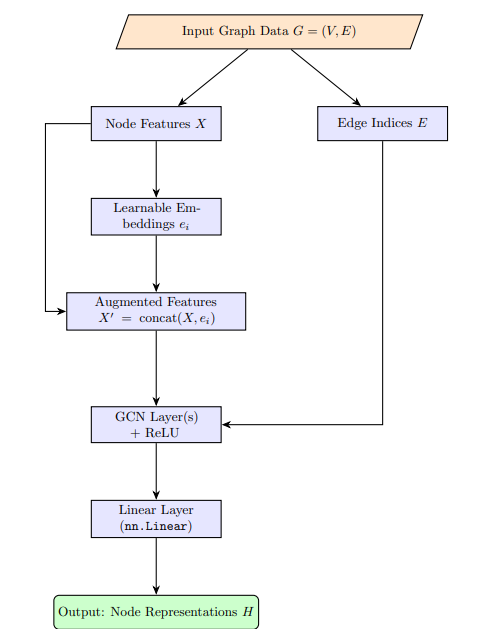

In [11]:
class GCNWithEmbedding(nn.Module):
    def __init__(self, num_nodes, initial_feature_dim, embedding_dim, hidden_channels, out_channels):
        '''
        initial_feature_dim: the length of the initial feature of each node. Since one-hot encoding is used, it is equal to num_nodes
        embedding_dim: embedding dimension
        out_channels: the length of the final node representation
        '''
        super(GCNWithEmbedding, self).__init__()
        self.node_embedding_layer = nn.Embedding(num_embeddings=num_nodes, embedding_dim=embedding_dim)
        self.conv1 = pyg_nn.GCNConv(initial_feature_dim + embedding_dim, hidden_channels) # Initial features and embedded features concatenation
        self.conv2 = pyg_nn.GCNConv(hidden_channels, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x_initial, edge_index):
        '''
        Input:
            x_initial: Initial node feature matrix (X_m), shape [num_nodes, initial_feature_dim].
            edge_index: Graph connectivity in COO format (E_m), shape [2, num_edges].

        Output: Learned node representation (H_m), shape [num_nodes, out_channels].
        '''
        num_input_nodes = x_initial.size(0)

        node_indices = torch.arange(num_input_nodes, device=x_initial.device)

        # Lookup node embeddings e_m using the correctly named layer
        node_embeds = self.node_embedding_layer(node_indices)

        # Concatenate initial features X_m and node embeddings e_m
        x_concat = torch.cat([x_initial, node_embeds], dim=1)

        h = self.conv1(x_concat, edge_index)
        h = self.relu(h)
        h = self.conv2(h, edge_index)
        h = self.relu(h)

        return h


## **Mixture Density Network (Gaussian Mixture Model)**

MDNHead 模块接收一个整合后的特征向量，先通过一个隐藏层进行信息提炼，随后利用三个专门的线性输出层分别计算出高斯混合模型的关键参数：经过LogSoftmax激活的对数混合权重(logπ
k
​
 )、经过指数和开方运算确保为正的标准差(σ
k
​
 )、以及直接输出的均值(μ
k
​
 )。这些参数共同定义了模型对目标变量（如薪酬）预测的完整条件概率分布。


  MDNHead module receives an integrated feature vector, extracts information through a hidden layer, and then uses three dedicated linear output layers to calculate the key parameters of the Gaussian mixture model: the logarithmic mixture weight (logπ
k
​
) activated by LogSoftmax, the standard deviation (σ
k
​
) ensured to be positive by exponential and square root operations, and the mean (μ
k
​
) output directly. Together, these parameters define the complete conditional probability distribution of the model's prediction of the target variable (e.g., salary).

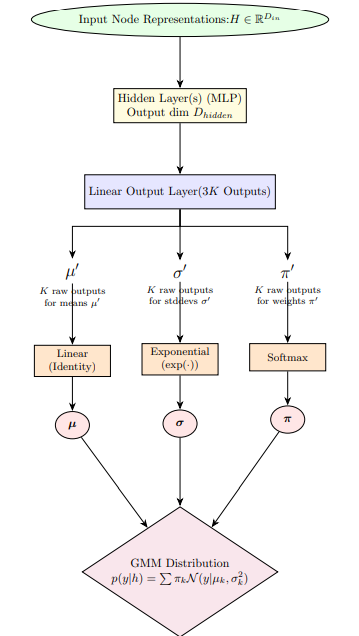

### **MDN Class**

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F # For Softmax, LogSoftmax, ReLU

class MDNHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_gaussians):
        """
        input_dim (int): Dimension of the input feature vector (h_comb).
        hidden_dim (int): Dimension of the hidden layer.
        num_gaussians (int): Number of Gaussian components (K) in the mixture model.
        """
        super(MDNHead, self).__init__()
        self.num_gaussians = num_gaussians

        self.fc_hidden = nn.Linear(input_dim, hidden_dim)
        # Output Heads for GMM parameters
        # These heads take the hidden representation h (output of fc_hidden) as input.

        # Head for Mixture Coefficients (Pi, π_k)
        #       Outputs K values, which after Softmax (or LogSoftmax)
        #       represent the weight of each Gaussian component.
        self.fc_pi = nn.Linear(hidden_dim, num_gaussians)

        #    b. Head for Variances (Sigma^2, σ_k^2)
        #       Outputs K values, which after an exponential function (exp())
        #       become positive variances.
        #       This linear layer is named fc_sigma_sq_logits as it outputs
        #       the values before they enter the exp() function.
        self.fc_sigma_sq_logits = nn.Linear(hidden_dim, num_gaussians)

        #    c. Head for Means (Mu, μ_k)
        #       Outputs K values representing the mean of each Gaussian component.
        #       Typically does not require an activation function.
        self.fc_mu = nn.Linear(hidden_dim, num_gaussians)

    def forward(self, x_input):
        """
        MDN Head: Forward pass. Defines how data flows through this head.

        Args:
            x_input (torch.Tensor): The integrated feature vector (h_comb) from the GCN part,
                                    shape [batch_size, input_dim].

        Returns:
            tuple: (log_pi, sigma, mu)
                log_pi (torch.Tensor): Log mixture coefficients for each Gaussian component,
                                       shape [batch_size, num_gaussians].
                                       Using log_softmax for numerical stability, facilitating NLL loss calculation.
                sigma (torch.Tensor):  Standard deviation (σ_k) of each Gaussian component,
                                       shape [batch_size, num_gaussians].
                                       Calculated from sigma_sq and ensured to be positive.
                mu (torch.Tensor):     Mean (μ_k) of each Gaussian component,
                                       shape [batch_size, num_gaussians].
        """
        #  Pass through the shared hidden layer
        h_shared = F.relu(self.fc_hidden(x_input))

        # Calculate the log of mixture coefficients (log_pi)
        #    Using log_softmax directly provides log probabilities, which is more stable for NLL loss calculation.
        log_pi = F.log_softmax(self.fc_pi(h_shared), dim=-1)

        # Calculate standard deviations (sigma)
        #    The output (logits) of the linear layer, when passed through an exp activation, yields the variance σ_k^2.
        sigma_sq_logits = self.fc_sigma_sq_logits(h_shared)
        sigma_sq = torch.exp(sigma_sq_logits)
        # To prevent numerical issues if variance is too small (e.g., in subsequent sqrt or division),
        sigma = torch.sqrt(sigma_sq + 1e-6) # 1e-6 (epsilon) for numerical stability

        sigma = torch.clamp(sigma, min=0.01) #Smooth the prediction

        # Calculate means (mu)
        mu = self.fc_mu(h_shared)

        return log_pi, sigma, mu

### **Loss Function: Negative Log-Likelihood loss for an MDN (mdn_nll_loss)**

该函数接收模型预测的三个混合高斯分布参数以及真实目标值 y_true，并利用这些参数稳定地计算出每个样本的对数似然，最终返回整个批次平均负对数似然作为损失值。

Define Loss to calculate the negative log-likelihood (NLL) of the mixture density network (MDN). This function receives the three mixed Gaussian distribution parameters predicted by the model and the true target value y_true, and uses these parameters to stably calculate the log-likelihood of each sample, and finally returns the average negative log-likelihood of the entire batch as the loss value。

对于负对数似然来说，Loss(log(概率密度))可能为负数. 这是因为如果模型预测某点的概率密度值大于1，那么它的对数 log(概率密度) 就会是正数。这意味着模型认为这个真实值出现的概率密度非常高（大于1）。因此，此时说明模型对它的预测非常有信心。

For Nll, Loss(log(probability density)) may be negative. If the model predicts that the probability density value of a point is greater than 1, then its logarithm log(probability density) will be positive. This means that the model believes that the probability density of this true value is very high (greater than 1). Therefore, this means that the model is very confident in its prediction.

In [13]:
import torch

def mdn_nll_loss(log_pi, sigma, mu, y_true):
    """
    Calculates the Negative Log-Likelihood loss for an MDN.
    log_pi: Log mixture coefficients, shape [batch_size, num_gaussians]
    sigma: Standard deviation of each Gaussian component, shape [batch_size, num_gaussians]
    mu: Mean of each Gaussian component, shape [batch_size, num_gaussians].
    y_true: True target values, shape [batch_size].
    """
    if y_true.dim() == 1:
        y_true = y_true.unsqueeze(-1)

    # It calculates log( P(y_true | mu_k, sigma_k) ) for each k (each Gaussian component).
    m = torch.distributions.Normal(loc=mu, scale=sigma) #Generate a Gaussian Distribution
    log_prob_y_given_k = m.log_prob(y_true)

    # log_sum_exp is a numerically stable way to compute log( sum_k exp(log_pi_k + log_prob_y_given_k) ).
    # This is equivalent to log( sum_k (pi_k * P(y_true|mu_k,sigma_k)) ), which is the log-likelihood of y_true under the GMM.
    log_likelihood = torch.logsumexp(log_pi + log_prob_y_given_k, dim=1) # Sum over the Gaussian components.

    # NLL loss: negative of the mean log-likelihood
    return -torch.mean(log_likelihood)

loss_fn = mdn_nll_loss

## **GCN-MDN Framework**
A general framework that organically combines GCN and MDN to work together

### **Define a GCNMDNModel Class**

定义并实例化一个完整的、端到端的GCN-MDN模型，包含所有组件

Define and instantiate a complete, end-to-end graph convolutional hybrid density network model
(GCNMDNModel)

### **Model's hierarchical fallback logic:**

When selecting features for each sample, **the model prioritizes the most specific information available using a hierarchical fallback logic**. For example, for the region attribute, it will first attempt to use the city-level (L4) data. If city information is missing for a given sample, it automatically falls back to using the province-level (L2) data, and finally, resorts to a general "Unknown" representation.

在为每个样本选择特征时，该模型会使用分层回退逻辑，优先考虑可用的最具体信息。例如，对于地区属性，它会首先尝试使用城市级别 (L4) 数据。如果给定样本缺少城市信息，它会自动回退到使用更广泛的省份级别 (L2) 数据；最后，如果两者都不可用，则采用通用的“未知”表示。

**How the model expresses "unknown" concepts:** Three dedicated learnable vectors are created: unknown_geo_embedding, unknown_occupation_embedding, and unknown_industry_embedding. They are defined as nn.Parameter, which tells PyTorch that they are model parameters and should be updated and optimized during training. During training, the model learns what this "unknown" vector should be. It adjusts the value of this vector to represent some kind of "average" or "baseline" impact of that attribute category.

模型如何表达“未知”概念：创建三个专用的可学习向量：unknown_geo_embedding、unknown_occupation_embedding和unknown_industry_embedding。它们被定义为nn.Parameter，这告诉 PyTorch 它们是模型参数，应该在训练期间进行更新和优化。在训练过程中，模型会学习这个“未知”向量应该是什么。它会调整这个向量的值，以表示该属性类别的某种“平均”或“基线”影响。

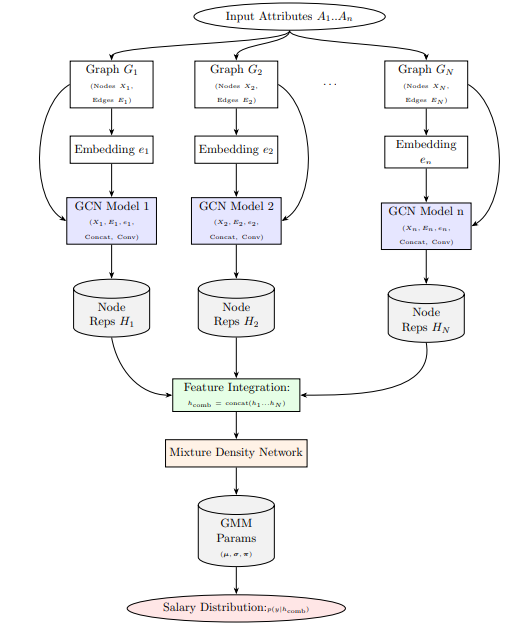

In [14]:
import torch.nn as nn
class GCNMDNModel(nn.Module):
    def __init__(self,
                 num_nodes_region, initial_feature_dim_region,
                 num_nodes_occupation, initial_feature_dim_occupation,
                 num_nodes_industry, initial_feature_dim_industry,
                 embedding_dim, gcn_hidden_channels,
                 gcn_out_channels, # The dimensions of the matrix of high-dimensional feature representations (embedding vectors)
                 mdn_input_feature_dim,
                 mdn_hidden_dim, num_gaussians):
        super().__init__()
        self.gcn_region = GCNWithEmbedding(num_nodes_region, initial_feature_dim_region, embedding_dim, gcn_hidden_channels, gcn_out_channels)
        self.gcn_occupation = GCNWithEmbedding(num_nodes_occupation, initial_feature_dim_occupation, embedding_dim, gcn_hidden_channels, gcn_out_channels)
        self.gcn_industry = GCNWithEmbedding(num_nodes_industry, initial_feature_dim_industry, embedding_dim, gcn_hidden_channels, gcn_out_channels)

        self.mdn_head = MDNHead(mdn_input_feature_dim, mdn_hidden_dim, num_gaussians)

        # Create learnable “unknown” embeddings for each attribute
        self.unknown_geo_embedding = nn.Parameter(torch.randn(1, gcn_out_channels))
        self.unknown_occupation_embedding = nn.Parameter(torch.randn(1, gcn_out_channels))
        self.unknown_industry_embedding = nn.Parameter(torch.randn(1, gcn_out_channels))

    def forward(self,
            x_region_full, edge_index_region_full,
            geo_l2_indices_batch, geo_l4_indices_batch,

            x_occupation_full, edge_index_occupation_full,
            occ_l1_indices_batch, occ_l2_indices_batch, occ_l6_indices_batch,

            x_industry_full, edge_index_industry_full,
            ind_l1_indices_batch, ind_l2_indices_batch
           ):
         # Get the representation of all nodes through GCN
         h_all_region_nodes = self.gcn_region(x_region_full, edge_index_region_full)
         h_all_occupation_nodes = self.gcn_occupation(x_occupation_full, edge_index_occupation_full)
         h_all_industry_nodes = self.gcn_industry(x_industry_full, edge_index_industry_full)

         batch_size = geo_l4_indices_batch.size(0) # Based on the size of any batch index
# Make sure unknown embeddings and gcn outputs are on the same device (usually handled when the model .to(device) is called)
# gcn_out_dim = self.gcn_region.conv2.out_channels # Assume that all GCN output dimensions are the same

    # Model's 【Hierarchical Fallback】 Logic
    # Location feature selection : L4 first, L2 fallback, Unknown last.
         h_selected_region = self.unknown_geo_embedding.repeat(batch_size, 1) # Initialize all samples in the batch with "unknown" embedding

         l2_geo_valid_mask = (geo_l2_indices_batch != -1) # Find samples that have valid L2
         if torch.any(l2_geo_valid_mask):
            valid_l2_geo_ids = geo_l2_indices_batch[l2_geo_valid_mask]
            h_selected_region[l2_geo_valid_mask] = h_all_region_nodes[valid_l2_geo_ids]

         l4_geo_valid_mask = (geo_l4_indices_batch != -1) # Find samples that have valid L4
         if torch.any(l4_geo_valid_mask):
            valid_l4_geo_ids = geo_l4_indices_batch[l4_geo_valid_mask]
            h_selected_region[l4_geo_valid_mask] = h_all_region_nodes[valid_l4_geo_ids] # Overwrite by L4

    # Occupation feature selection (L6 > L2 > L1 > Unknown) ---
         h_selected_occupation = self.unknown_occupation_embedding.repeat(batch_size, 1)

         l1_occ_valid_mask = (occ_l1_indices_batch != -1)
         if torch.any(l1_occ_valid_mask):
            valid_l1_occ_ids = occ_l1_indices_batch[l1_occ_valid_mask]
            h_selected_occupation[l1_occ_valid_mask] = h_all_occupation_nodes[valid_l1_occ_ids]

         l2_occ_valid_mask = (occ_l2_indices_batch != -1)
         if torch.any(l2_occ_valid_mask):
            valid_l2_occ_ids = occ_l2_indices_batch[l2_occ_valid_mask]
            h_selected_occupation[l2_occ_valid_mask] = h_all_occupation_nodes[valid_l2_occ_ids]

         l6_occ_valid_mask = (occ_l6_indices_batch != -1)
         valid_l6_occ_ids = occ_l6_indices_batch[l6_occ_valid_mask]
         h_selected_occupation[l6_occ_valid_mask] = h_all_occupation_nodes[valid_l6_occ_ids]

    # Industry feature selection (L2 > L1 > Unknown)
         h_selected_industry = self.unknown_industry_embedding.repeat(batch_size, 1)

         l1_ind_valid_mask = (ind_l1_indices_batch != -1)
         if torch.any(l1_ind_valid_mask):
            valid_l1_ind_ids = ind_l1_indices_batch[l1_ind_valid_mask]
            h_selected_industry[l1_ind_valid_mask] = h_all_industry_nodes[valid_l1_ind_ids]

         l2_ind_valid_mask = (ind_l2_indices_batch != -1)
         if torch.any(l2_ind_valid_mask):
            valid_l2_ind_ids = ind_l2_indices_batch[l2_ind_valid_mask]
            h_selected_industry[l2_ind_valid_mask] = h_all_industry_nodes[valid_l2_ind_ids]

    # Concatenate three representations to form h_comb
         h_comb = torch.cat([h_selected_region, h_selected_occupation, h_selected_industry], dim=1)

    # Get distribution parameters through MDN header
         log_pi, sigma, mu = self.mdn_head(h_comb)
         return log_pi, sigma, mu


## **Preparing Data**

### **Standardize Salary Data**

In [15]:
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [16]:
required_string_attribute_columns = [
    'geo_level_2_string',
    'geo_level_4_string',
    'occupation_level_1_name',
    'occupation_level_2_name',
    'occupation_level_6_name',
    'industry_1_name',
    'industry_2_name'
]
target_salary_column = 'log_average'

columns_to_select = required_string_attribute_columns + [target_salary_column]
prepared_training_df = data[columns_to_select].copy()

In [17]:
# Standardize Salary Data
from sklearn.preprocessing import StandardScaler
salary_scaler = StandardScaler()
prepared_training_df['average_log_scaled'] = salary_scaler.fit_transform(prepared_training_df[['log_average']])

In [18]:
prepared_training_df.columns, prepared_training_df.shape, prepared_training_df['average_log_scaled'].head(5)

(Index(['geo_level_2_string', 'geo_level_4_string', 'occupation_level_1_name',
        'occupation_level_2_name', 'occupation_level_6_name', 'industry_1_name',
        'industry_2_name', 'log_average', 'average_log_scaled'],
       dtype='object'),
 (467571, 9),
 0   -0.693330
 1    1.124643
 2   -0.325782
 3   -0.992751
 4   -1.760822
 Name: average_log_scaled, dtype: float64)

### **Encapsulate data as Salarydataset**
SalaryDataset:类封装预处理后的数据，为模型训练逐个提供包含节点ID和真实薪酬的样本。对每个样本，都记录下所有相关层级的节点ID。如果某个层级信息缺失，记为-1。

SalaryDataset: This class encapsulates the preprocessed data and provides samples containing node IDs and real salaries for model training. For each sample, the node IDs of all relevant levels are recorded. If a level information is missing, it is recorded as -1.



In [19]:
import torch
from torch.utils.data import Dataset
class SalaryDataset(Dataset):
    def __init__(self, dataframe, node_mapping_region, node_mapping_occupation, node_mapping_industry):
        self.df = dataframe

        # Pre-calculate node indices for all relevant columns
        # Using .apply(lambda x: node_mapping.get(x, -1)) is generally safer and cleaner
        # Also, ensure the columns exist before accessing them.

        # Assuming these columns exist in the original dataframe passed to the constructor
        self.geo_l2_indices = torch.tensor(
            self.df['geo_level_2_string'].apply(lambda name: node_mapping_region.get(name, -1)).values,
            dtype=torch.long
        )
        self.geo_l4_indices = torch.tensor(
            self.df['geo_level_4_string'].apply(lambda name: node_mapping_region.get(name, -1)).values,
            dtype=torch.long
        )

        self.occ_l1_indices = torch.tensor(
            self.df['occupation_level_1_name'].apply(lambda name: node_mapping_occupation.get(name, -1)).values,
            dtype=torch.long
        )
        self.occ_l2_indices = torch.tensor(
            self.df['occupation_level_2_name'].apply(lambda name: node_mapping_occupation.get(name, -1)).values,
            dtype=torch.long
        )
        self.occ_l6_indices = torch.tensor(
            self.df['occupation_level_6_name'].apply(lambda name: node_mapping_occupation.get(name, -1)).values,
            dtype=torch.long
        )

        self.ind_l1_indices = torch.tensor(
            self.df['industry_1_name'].apply(lambda name: node_mapping_industry.get(name, -1)).values,
            dtype=torch.long
        )
        self.ind_l2_indices = torch.tensor(
            self.df['industry_2_name'].apply(lambda name: node_mapping_industry.get(name, -1)).values,
            dtype=torch.long
        )

        self.salaries = torch.tensor(self.df['average_log_scaled'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.salaries)

    def __getitem__(self, idx):
        return {
            'geo_l2_idx': self.geo_l2_indices[idx],
            'geo_l4_idx': self.geo_l4_indices[idx],
            'occ_l1_idx': self.occ_l1_indices[idx],
            'occ_l2_idx': self.occ_l2_indices[idx],
            'occ_l6_idx': self.occ_l6_indices[idx],
            'ind_l1_idx': self.ind_l1_indices[idx],
            'ind_l2_idx': self.ind_l2_indices[idx],
            'salary': self.salaries[idx]
        }


### **Initialize the node feature matrix (x_initial_region_full) and the connection between all nodes (edge_index)**



In [20]:
# Node feature matrix (Identity Matrix) for each graph
x_initial_region_full = torch.eye(num_nodes_region, dtype=torch.float)
x_initial_occupation_full = torch.eye(num_nodes_occupation, dtype=torch.float)
x_initial_industry_full = torch.eye(num_nodes_industry, dtype=torch.float)

# Send them to CPU/GPU
x_initial_region_full = x_initial_region_full.to(device)
edge_index_region_full = edge_region_index.to(device) #Previously Defined
x_initial_occupation_full = x_initial_occupation_full.to(device)
edge_index_occupation_full = edge_occupation_index.to(device)
x_initial_industry_full = x_initial_industry_full.to(device)
edge_index_industry_full = edge_industry_index.to(device)

In [21]:
print(x_initial_region_full.shape, edge_index_region_full.shape,
x_initial_occupation_full.shape, edge_index_occupation_full.shape,
x_initial_industry_full.shape, edge_index_industry_full.shape)

torch.Size([420, 420]) torch.Size([2, 409]) torch.Size([2844, 2844]) torch.Size([2, 2831]) torch.Size([103, 103]) torch.Size([2, 83])


## **Model Training**

**Train-Test Split**

In [22]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(prepared_training_df,test_size=0.2,random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

Training samples: 374056
Validation samples: 93515


In [23]:
from torch.utils.data import Dataset, DataLoader
# Convert original Dataset to standard training bags
train_dataset = SalaryDataset(train_df,
                               node_mapping_region,
                               node_mapping_occupation,
                               node_mapping_industry)
val_dataset = SalaryDataset(val_df,
                               node_mapping_region,
                               node_mapping_occupation,
                               node_mapping_industry)
# DataLoader: Take "standard training bags" from the SalaryDataset in batches and feed them into model
batch_size = 512
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False)

type(train_dataset), type(train_dataloader)

(__main__.SalaryDataset, torch.utils.data.dataloader.DataLoader)

### **Hyperparameter Optimization**

对于超参数优化，objective 函数接收一组试验性的超参数，然后返回验证集上评估模型的性能。Optuna: 一个超参数优化库，它会反复调用这个 objective 函数，智能地探索超参数空间，以找到使返回的指标最小化（或最大化）的超参数组合。

For hyperparameter optimization, we set a objective function, which receives a set of experimental hyperparameters and returns the performance of the model evaluated on the validation set.

**Optuna**: A hyperparameter optimization library that repeatedly calls this objective function to intelligently explore the hyperparameter space to find the hyperparameter combination that minimizes (or maximizes) the returned metric.

In [ ]:
!pip install optuna

In [25]:
import optuna
import torch
import torch.optim as optim
from time import time

In our model, **the number of gaussian components and learning rate** are the two hyperparameters that have the greatest impact on the training results. Therefore, we only perform optimal search for these two hyperparameters.

In [26]:
def objective(trial):
    lr = trial.suggest_categorical('lr', [1e-3,  1e-4,  1e-5])
    num_gaussians = trial.suggest_int('gaussian_com', 1, 10, step=1)

    # Fixed Hyperparameters
    embedding_dim = 32
    gcn_hidden_channels = 64
    gcn_out_channels = 32
    mdn_hidden_dim = 128
    num_nodes_region = len(node_mapping_region)
    num_nodes_occupation = len(node_mapping_occupation)
    num_nodes_industry = len(node_mapping_industry)

    initial_feature_dim_region = x_initial_region_full.shape[1]
    initial_feature_dim_occupation = x_initial_occupation_full.shape[1]
    initial_feature_dim_industry = x_initial_industry_full.shape[1]

    num_concatenated_embeddings_in_model_forward = 3
    calculated_mdn_input_feature_dim = num_concatenated_embeddings_in_model_forward * gcn_out_channels

    overall_model = GCNMDNModel(
        num_nodes_region=num_nodes_region, initial_feature_dim_region=initial_feature_dim_region,
        num_nodes_occupation=num_nodes_occupation, initial_feature_dim_occupation=initial_feature_dim_occupation,
        num_nodes_industry=num_nodes_industry, initial_feature_dim_industry=initial_feature_dim_industry,
        embedding_dim=embedding_dim,
        gcn_hidden_channels=gcn_hidden_channels,
        gcn_out_channels=gcn_out_channels,
        mdn_input_feature_dim=calculated_mdn_input_feature_dim,
        mdn_hidden_dim=mdn_hidden_dim,
        num_gaussians=num_gaussians,
    ).to(device)

    optimizer = optim.Adam(overall_model.parameters(), lr=lr)

    num_epochs_trial = 40 # Use fewer epochs
    best_val_loss = float('inf')

    for epoch in range(num_epochs_trial):
        overall_model.train()
        epoch_train_loss = 0
        for batch_idx, batch_data in enumerate(train_dataloader):
            geo_l2_idx_batch = batch_data['geo_l2_idx'].to(device)
            geo_l4_idx_batch = batch_data['geo_l4_idx'].to(device)
            occ_l1_idx_batch = batch_data['occ_l1_idx'].to(device)
            occ_l2_idx_batch = batch_data['occ_l2_idx'].to(device)
            occ_l6_idx_batch = batch_data['occ_l6_idx'].to(device)
            ind_l1_idx_batch = batch_data['ind_l1_idx'].to(device)
            ind_l2_idx_batch = batch_data['ind_l2_idx'].to(device)
            salaries_batch = batch_data['salary'].to(device)

            optimizer.zero_grad()

            log_pi, sigma, mu = overall_model(
                x_initial_region_full, edge_index_region_full, geo_l2_idx_batch, geo_l4_idx_batch,
                x_initial_occupation_full, edge_index_occupation_full, occ_l1_idx_batch, occ_l2_idx_batch, occ_l6_idx_batch,
                x_initial_industry_full, edge_index_industry_full, ind_l1_idx_batch, ind_l2_idx_batch
            )
            loss = mdn_nll_loss(log_pi, sigma, mu, salaries_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(overall_model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_train_loss += loss.item()

        # Val
        overall_model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for val_batch_data in val_dataloader:
                val_geo_l2_idx = val_batch_data['geo_l2_idx'].to(device)
                val_geo_l4_idx = val_batch_data['geo_l4_idx'].to(device)
                val_occ_l1_idx = val_batch_data['occ_l1_idx'].to(device)
                val_occ_l2_idx = val_batch_data['occ_l2_idx'].to(device)
                val_occ_l6_idx = val_batch_data['occ_l6_idx'].to(device)
                val_ind_l1_idx = val_batch_data['ind_l1_idx'].to(device)
                val_ind_l2_idx = val_batch_data['ind_l2_idx'].to(device)
                val_salaries_batch = val_batch_data['salary'].to(device)

                val_log_pi, val_sigma, val_mu = overall_model(
                    x_initial_region_full, edge_index_region_full,
                    val_geo_l2_idx, val_geo_l4_idx,
                    x_initial_occupation_full, edge_index_occupation_full,
                    val_occ_l1_idx, val_occ_l2_idx, val_occ_l6_idx,
                    x_initial_industry_full, edge_index_industry_full,
                    val_ind_l1_idx, val_ind_l2_idx
                )
                current_val_loss = mdn_nll_loss(val_log_pi, val_sigma, val_mu, val_salaries_batch)
                epoch_val_loss += current_val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_dataloader)

        # Report intermediate results to Optuna for pruning
        trial.report(avg_val_loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

    return avg_val_loss

In [27]:
t0 = time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

study = optuna.create_study(direction='minimize', study_name='gcnmdn_hyperparameter_tuning')
#Find the hyperparameter combination that minimizes the objective function value

# Run optimazing process
study.optimize(objective, n_trials=50, timeout=3600*24) # Run 50 experiments, or up to 24 hours
t1 = time()

print("Hyperparameter optimization time:", (t1-t0))

print("Number of finished trials:", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Visualization of Optuna
import optuna.visualization as ov
ov.plot_optimization_history(study)
ov.plot_slice(study)
ov.plot_param_importances(study)

[I 2025-07-03 09:23:21,298] A new study created in memory with name: gcnmdn_hyperparameter_tuning
[W 2025-07-03 09:31:43,680] Trial 0 failed with parameters: {'lr': 0.0001, 'gaussian_com': 4} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-26-1724943923.py", line 41, in objective
    for batch_idx, batch_data in enumerate(train_dataloader):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 708, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 764, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dis

KeyboardInterrupt: 

**Best Params Found After 50 Trials: learning rate: 0.001 gaussian_components: 8**

### **Train the model using the found "good" hyperparameter combination**

**Instantiate the model with the best parameter combination (num_gaussians and learning rate) found.**

In [28]:
#Define GCN and Embedding hyperparameters
initial_feature_dim_region = num_nodes_region = len(node_mapping_region) #420
initial_feature_dim_occupation = num_nodes_occupation = len(node_mapping_occupation) #2806
initial_feature_dim_industry = num_nodes_industry = len(node_mapping_industry) #103

embedding_dim = 32
gcn_hidden_channels = 64
gcn_out_channels = 32
mdn_input_feature_dim = gcn_out_channels * 3
mdn_hidden_dim = 128
num_gaussians = 9 #Hyperpara

print("Instantiating GCNMDNModel...")
overall_model = GCNMDNModel(
    num_nodes_region=num_nodes_region,
    initial_feature_dim_region=initial_feature_dim_region,
    num_nodes_occupation=num_nodes_occupation,
    initial_feature_dim_occupation=initial_feature_dim_occupation,
    num_nodes_industry=num_nodes_industry,
    initial_feature_dim_industry=initial_feature_dim_industry,
    embedding_dim=embedding_dim,
    gcn_hidden_channels=gcn_hidden_channels,
    gcn_out_channels=gcn_out_channels,
    mdn_input_feature_dim=mdn_input_feature_dim,
    mdn_hidden_dim=mdn_hidden_dim,
    num_gaussians=num_gaussians
).to(device)

Instantiating GCNMDNModel...


In [29]:
from torch.utils.data import Dataset, DataLoader
from time import time
import torch.optim as optim
# All necessary components are defined and initialized before this:
# 1. SalaryDataset class (updated to provide hierarchical indices)
# 2. GCNWithEmbedding class
# 3. MDNHead class
# 4. GCNMDNModel class (updated to accept hierarchical indices in forward pass
#    and to have unknown_geo/occ/ind_embedding parameters)
# 5. mdn_nll_loss function
# 6. node_mapping_region, node_mapping_occupation, node_mapping_industry dictionaries
# 7. Full graph data:
#    x_initial_region_full, edge_index_region_full
#    x_initial_occupation_full, edge_index_occupation_full
#    x_initial_industry_full, edge_index_industry_full
#    (These should be on the correct device or moved to device before the loop)
# 8. prepared_training_df (Pandas DataFrame with mapped string names to integer IDs for ALL relevant levels)
# 9. overall_model (instance of GCNMDNModel, moved to device)
# 10. optimizer (for overall_model.parameters())
# 11. device (torch.device)
#---------------------------------------------------------------------------------


train_losses = []
val_losses = []
val_epochs = []


num_epochs = 500
optimizer = optim.Adam(overall_model.parameters(), lr=0.001)
print("\nStarting training")
Start_time =  time()
for epoch in range(num_epochs):
    start_time = time()
    overall_model.train() # Set the model to training mode
    epoch_train_loss = 0
    num_batches = len(train_dataloader)

    for batch_idx, batch_data in enumerate(train_dataloader): # train_dataloader now yields dicts with hierarchical keys
        # Extract the node ID and real salary of each level in this batch
        geo_l2_idx_batch = batch_data['geo_l2_idx'].to(device)
        geo_l4_idx_batch = batch_data['geo_l4_idx'].to(device)
        occ_l1_idx_batch = batch_data['occ_l1_idx'].to(device)
        occ_l2_idx_batch = batch_data['occ_l2_idx'].to(device)
        occ_l6_idx_batch = batch_data['occ_l6_idx'].to(device)
        ind_l1_idx_batch = batch_data['ind_l1_idx'].to(device)
        ind_l2_idx_batch = batch_data['ind_l2_idx'].to(device)

        salaries_batch = batch_data['salary'].to(device)

        optimizer.zero_grad() #Before calculating a new error each time, the gradient must be cleared

        # 2. Forward pass through the model
        # Feed all the complete graph data (x_initial_..._full, edge_index_..._full)
        # and the node IDs of each level corresponding to the current batch of samples (..._idx_batch)
        # to overall_model (GCNMDN model). This model will output log_pi, sigma, mu.
        log_pi, sigma, mu = overall_model(
            x_initial_region_full,         # Node feature matrix (identity matrix)
            edge_index_region_full,        # Connections between all nodes
            geo_l2_idx_batch,              # node IDs of level 2 corresponding to the [current batch] of samples
            geo_l4_idx_batch,              # node IDs of level 4 corresponding to the [current batch] of samples

            x_initial_occupation_full, edge_index_occupation_full, #Similar as above
            occ_l1_idx_batch, occ_l2_idx_batch, occ_l6_idx_batch,

            x_initial_industry_full, edge_index_industry_full,
            ind_l1_idx_batch, ind_l2_idx_batch)


        loss = mdn_nll_loss(log_pi, sigma, mu, salaries_batch) # Pre-defined loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(overall_model.parameters(), max_norm=1.0) # Gradient clipping. Use bcs I encountered the gradient explosion problem during the first run.
        optimizer.step()

        epoch_train_loss += loss.item()
        if (batch_idx + 1) % 100 == 0:
            print(f'    Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx + 1}/{num_batches}], Current Loss: {loss.item():.4f}')

    end_time = time()

    avg_train_loss = epoch_train_loss / num_batches
    train_losses.append(avg_train_loss)

    print(f"--- Epoch [{epoch+1}/{num_epochs}] Summary ---")
    print(f"    Average Loss: {avg_train_loss:.4f}")
    print(f"    Time for Train Epoch: {end_time - start_time:.2f}s")
    print("-----------------------------------")



    if (epoch + 1) % 3 == 0: # Verify every 3 epochs
        print("\nStarting training with validation")
        overall_model.eval()
        epoch_val_loss = 0.0
        num_val_batches = len(val_dataloader)

        with torch.no_grad():
            for val_batch_data in val_dataloader:
                # Extract Batch Data
                val_geo_l2_idx = val_batch_data['geo_l2_idx'].to(device)
                val_geo_l4_idx = val_batch_data['geo_l4_idx'].to(device)
                val_occ_l1_idx = val_batch_data['occ_l1_idx'].to(device)
                val_occ_l2_idx = val_batch_data['occ_l2_idx'].to(device)
                val_occ_l6_idx = val_batch_data['occ_l6_idx'].to(device)
                val_ind_l1_idx = val_batch_data['ind_l1_idx'].to(device)
                val_ind_l2_idx = val_batch_data['ind_l2_idx'].to(device)
                val_salaries_batch = val_batch_data['salary'].to(device)

                # Forward pass
                val_log_pi, val_sigma, val_mu = overall_model(
                    x_initial_region_full, edge_index_region_full,
                    val_geo_l2_idx, val_geo_l4_idx,

                    x_initial_occupation_full, edge_index_occupation_full,
                    val_occ_l1_idx, val_occ_l2_idx, val_occ_l6_idx,

                    x_initial_industry_full, edge_index_industry_full,
                    val_ind_l1_idx, val_ind_l2_idx
                )

                current_val_loss = mdn_nll_loss(val_log_pi, val_sigma, val_mu, val_salaries_batch)
                epoch_val_loss += current_val_loss.item()

        avg_val_loss = epoch_val_loss / num_val_batches
        val_losses.append(avg_val_loss)
        val_epochs.append(epoch + 1)
        print(f"    Validation Loss: {avg_val_loss:.4f}")
        print("---------------------------------")

End_time = time()
print(f"   Total time for training: {End_time - Start_time:.2f}s")
print("---------------------------------")
print("Training finished.")


Streaming output truncated to the last 5000 lines.
    Time for Train Epoch: 19.72s
-----------------------------------
    Epoch [96/500], Batch [100/731], Current Loss: 0.3854
    Epoch [96/500], Batch [200/731], Current Loss: 0.3868
    Epoch [96/500], Batch [300/731], Current Loss: 0.3522
    Epoch [96/500], Batch [400/731], Current Loss: 0.3688
    Epoch [96/500], Batch [500/731], Current Loss: 0.2422
    Epoch [96/500], Batch [600/731], Current Loss: 0.3370
    Epoch [96/500], Batch [700/731], Current Loss: 0.2937
--- Epoch [96/500] Summary ---
    Average Loss: 0.3119
    Time for Train Epoch: 20.02s
-----------------------------------

Starting training with validation
    Validation Loss: 0.4742
---------------------------------
    Epoch [97/500], Batch [100/731], Current Loss: 0.3014
    Epoch [97/500], Batch [200/731], Current Loss: 0.3638
    Epoch [97/500], Batch [300/731], Current Loss: 0.4302
    Epoch [97/500], Batch [400/731], Current Loss: 0.2856
    Epoch [97/500], 

In [30]:
print(f"   Avg time for training per epoch: {(End_time - Start_time)/(num_epochs):.2f}s")

   Avg time for training per epoch: 21.15s


In [31]:
train_losses_last_10 = train_losses[-10:]  # Get the last 10 training losses
val_losses_last_10 = val_losses[-10:]

train_loss_avg = sum(train_losses_last_10) / len(train_losses_last_10)
val_loss_avg = sum(val_losses_last_10) / len(val_losses_last_10)

print(f"Train Loss (Epoch 500) average of last 10: {train_loss_avg}")
print(f"Validation Loss (Epoch 500) average of last 10: {val_loss_avg}")

Train Loss (Epoch 500) average of last 10: 0.1786185234206666
Validation Loss (Epoch 500) average of last 10: 0.43736897695585675


In [32]:
filename = 'validation_losses_0703.txt'
filename2 = 'train_losses_0703.txt'

with open(filename, 'w') as f:
    for loss in val_losses:
        f.write(f"{loss}\n")

with open(filename2, 'w') as f:
    for loss in train_losses:
        f.write(f"{loss}\n")

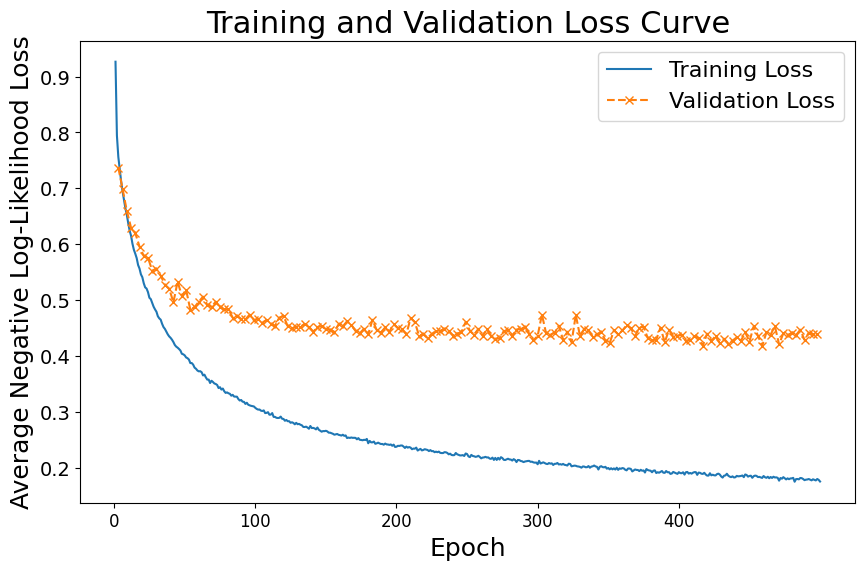

In [33]:
#Loss Curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, linestyle='-', label='Training Loss')

if val_losses:
    plt.plot(val_epochs, val_losses, marker='x', linestyle='--', label='Validation Loss')

plt.title("Training and Validation Loss Curve", fontsize=22)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Average Negative Log-Likelihood Loss", fontsize=18)
plt.legend(fontsize=16)


tick_interval = 100
plt.xticks(np.arange(0, num_epochs, tick_interval), fontsize=12)
plt.yticks(fontsize=14)

plt.show()

In [34]:
MODEL_SAVE_PATH = 'model_0703.pth'
torch.save(overall_model.state_dict(), MODEL_SAVE_PATH)

## **Model Prediction**

### **Load Model**

In [49]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

mdn_input_dim = gcn_out_channels * 3
mdn_hidden_dim = 128
num_gaussians = 9

# Re-instantiate a model with exactly the same structure as during training
loaded_model = GCNMDNModel(
    num_nodes_region=num_nodes_region, initial_feature_dim_region=initial_feature_dim_region,
    num_nodes_occupation=num_nodes_occupation, initial_feature_dim_occupation=initial_feature_dim_occupation,
    num_nodes_industry=num_nodes_industry, initial_feature_dim_industry=initial_feature_dim_industry,
    embedding_dim=embedding_dim, gcn_hidden_channels=gcn_hidden_channels, gcn_out_channels=gcn_out_channels,
    mdn_input_feature_dim=mdn_input_dim, mdn_hidden_dim=mdn_hidden_dim, num_gaussians=num_gaussians)

loaded_model.load_state_dict(torch.load('model_0703.pth'))

loaded_model.to(device)
loaded_model.eval()

GCNMDNModel(
  (gcn_region): GCNWithEmbedding(
    (node_embedding_layer): Embedding(420, 32)
    (conv1): GCNConv(452, 64)
    (conv2): GCNConv(64, 32)
    (relu): ReLU()
  )
  (gcn_occupation): GCNWithEmbedding(
    (node_embedding_layer): Embedding(2844, 32)
    (conv1): GCNConv(2876, 64)
    (conv2): GCNConv(64, 32)
    (relu): ReLU()
  )
  (gcn_industry): GCNWithEmbedding(
    (node_embedding_layer): Embedding(103, 32)
    (conv1): GCNConv(135, 64)
    (conv2): GCNConv(64, 32)
    (relu): ReLU()
  )
  (mdn_head): MDNHead(
    (fc_hidden): Linear(in_features=96, out_features=128, bias=True)
    (fc_pi): Linear(in_features=128, out_features=9, bias=True)
    (fc_sigma_sq_logits): Linear(in_features=128, out_features=9, bias=True)
    (fc_mu): Linear(in_features=128, out_features=9, bias=True)
  )
)

### **Prediction Function**

First, define the research group: give a series of screening conditions, such as region in Amsterdam or Utrecht, industry in Manufacturing or Retail, and occupation in ICT managers. Then it could predict an overall salary distribution for this screened group by defining a predict_group_distribution function.

In [129]:
from itertools import product
from scipy.stats import norm
import pandas as pd
from scipy.stats import norm, lognorm

# Case insensitive when entering attribute names
def find_key_case_insensitive(data_dict, target_key):
    #key: existing attribute name target_key: input attribute name. Lowercase them all. If a match is found, enter the original existing attribute name"
    if pd.isna(target_key):
        return None #Avoid NAN

    target_key_lower = str(target_key).lower()
    for key in data_dict.keys():
        if str(key).lower() == target_key.lower():
            return key
    return None


def get_sample_count(value, attr_name, df):
    """
    Counts the total occurrences of a specific attribute 'value'
    across all relevant columns in the DataFrame 'df'.

    Args:
        value (str): The specific attribute value to count (e.g., 'Amsterdam').
        attr_name (str): The general category to search for (e.g., 'geo', 'industry').
        df (pd.DataFrame): The original data DataFrame to search within.

    Returns:
        int: The total count of rows where the value appears.
    """
    # 1. If the input value is None, there's nothing to count.
    if value is None:
        return 0

    # 2. Identify all possible columns in the DataFrame related to the attribute name.
    #    For example, if attr_name is 'geo', this will find 'geo_level_2_string', 'geo_level_4_string'.
    possible_cols = [col for col in df.columns if attr_name in col and col.endswith(('_name', '_string'))]

    if not possible_cols:
        print(f"Warning: No columns found for attribute type '{attr_name}'")
        return 0

    # 3. Find the actual, case-correct version of the 'value' as it exists in the data.
    #    This is important because 'amsterdam' and 'Amsterdam' should be treated the same.
    #    We create a temporary set of all unique values from the relevant columns to search in.
    all_unique_values_in_cols = pd.concat([df[col].dropna() for col in possible_cols]).unique()
    temp_mapping_dict = {str(v): str(v) for v in all_unique_values_in_cols}

    original_key = find_key_case_insensitive(temp_mapping_dict, value)

    # 4. If the key doesn't exist in the data at all, its count is 0.
    if not original_key:
        return 0

    # 5. Sum the occurrences of the original_key across all relevant columns.
    total_count = 0
    for col in possible_cols:
        # (df[col] == original_key) creates a boolean Series (True where match)
        # .sum() on a boolean Series counts the number of True values.
        total_count += (df[col] == original_key).sum()

    return total_count




In [148]:
def predict_group_distribution(
    model,
    # --- User Inputs: Lists of strings ---
    region_names: list = None,
    industry_names: list = None,
    occupation_names: list = None,
):
    """
    Predicts both the weighted average salary and the aggregate salary
    distribution for a group, assuming the model was trained on
    log-transformed and standardized salary data.
    """
    print("\n--- Starting Group Prediction (for Log-Transformed Model) ---")

    # Ensure inputs are lists for itertools.product
    region_names = region_names if region_names else [None]
    industry_names = industry_names if industry_names else [None]
    occupation_names = occupation_names if occupation_names else [None]

    # 1. Generate all attribute combinations
    all_combinations = list(product(region_names, industry_names, occupation_names))
    print(f"Generated {len(all_combinations)} combination(s) to predict.")

    model.eval()
    predictions_data = [] # Will store parameters and weights for each combo

    # 2. Predict GMM parameters for each combination
    for combo in all_combinations:
        # ... (The logic to get node IDs for each combo remains the same as before)
        region_name, industry_name, occupation_name = combo
        geo_l2_idx, geo_l4_idx, occ_l1_idx, occ_l2_idx, occ_l6_idx, ind_l1_idx, ind_l2_idx = [-1]*7
        if region_name and region_name in G_region.nodes:
            node_type = G_region.nodes[region_name]['type']
            node_id = node_mapping_region.get(region_name, -1)
            if node_type == 'geo_level_2': geo_l2_idx = node_id
            elif node_type == 'geo_level_4': geo_l4_idx = node_id
        if occupation_name and occupation_name in G_occupation.nodes:
            node_type = G_occupation.nodes[occupation_name]['type']
            node_id = node_mapping_occupation.get(occupation_name, -1)
            if node_type == 'occupation_level_1': occ_l1_idx = node_id
            elif node_type == 'occupation_level_2': occ_l2_idx = node_id
            elif node_type == 'occupation_level_6': occ_l6_idx = node_id
        if industry_name and industry_name in G_industry.nodes:
            node_type = G_industry.nodes[industry_name]['type']
            node_id = node_mapping_industry.get(industry_name, -1)
            if node_type == 'industry_level_1': ind_l1_idx = node_id
            elif node_type == 'industry_level_2': ind_l2_idx = node_id
        geo_l2_idx_batch = torch.tensor([geo_l2_idx], dtype=torch.long, device=device)
        geo_l4_idx_batch = torch.tensor([geo_l4_idx], dtype=torch.long, device=device)
        occ_l1_idx_batch = torch.tensor([occ_l1_idx], dtype=torch.long, device=device)
        occ_l2_idx_batch = torch.tensor([occ_l2_idx], dtype=torch.long, device=device)
        occ_l6_idx_batch = torch.tensor([occ_l6_idx], dtype=torch.long, device=device)
        ind_l1_idx_batch = torch.tensor([ind_l1_idx], dtype=torch.long, device=device)
        ind_l2_idx_batch = torch.tensor([ind_l2_idx], dtype=torch.long, device=device)

        with torch.no_grad():
            log_pi, sigma_scaled, mu_scaled = model(x_initial_region_full, edge_index_region_full,
        geo_l2_idx_batch, geo_l4_idx_batch,
        x_initial_occupation_full, edge_index_occupation_full,
        occ_l1_idx_batch, occ_l2_idx_batch, occ_l6_idx_batch,
        x_initial_industry_full, edge_index_industry_full,
        ind_l1_idx_batch, ind_l2_idx_batch)

        # --- MODIFICATION: Correct inverse transform and expectation calculation ---
        pi = torch.exp(log_pi).squeeze(0).cpu().numpy()
        mu_scaled_np = mu_scaled.squeeze(0).cpu().numpy()
        sigma_scaled_np = sigma_scaled.squeeze(0).cpu().numpy()

        # Step A: Inverse-standardize to get parameters on the LOG-SCALE
        mu_log = salary_scaler.inverse_transform(mu_scaled_np.reshape(-1, 1)).flatten()
        sigma_log = sigma_scaled_np * salary_scaler.scale_[0]

        # Step B: Calculate the expected value for a Log-Normal Mixture
        # E[Y] = sum(pi_k * exp(mu_log_k + sigma_log_k^2 / 2))
        expected_salary_real = np.sum(pi * np.exp(mu_log + (sigma_log**2) / 2))
        # --------------------------------------------------------------------

        # Calculate weight for this combination
        weights = []
        if combo[0]: weights.append(get_sample_count(combo[0], 'geo', data))
        if combo[1]: weights.append(get_sample_count(combo[1], 'industry', data))
        if combo[2]: weights.append(get_sample_count(combo[2], 'occupation', data))
        weight = min(weights) if weights else 0

        predictions_data.append({
            'combination': combo,
            'predicted_salary': expected_salary_real, # Now this is the correct point estimate
            'pi': pi,
            'mu_log': mu_log,         # Store log-scale mu for plotting
            'sigma_log': sigma_log,   # Store log-scale sigma for plotting
            'weight': weight
        })

    # --- 3. Calculate Final Weighted Average and Aggregate Distribution ---
    # The weighted average calculation logic remains the same, but now uses the corrected salary
    total_weighted_salary_sum = 0
    total_weight = sum(p['weight'] for p in predictions_data)

    print("\n--- Individual Combination Predictions ---")
    for p in predictions_data:
        print(f"  Combination: {p['combination']}, Predicted E[Salary]: {p['predicted_salary']:.2f}, Weight: {p['weight']}")
        total_weighted_salary_sum += p['predicted_salary'] * p['weight']

    weighted_average_salary = 0
    if total_weight > 0:
        weighted_average_salary = total_weighted_salary_sum / total_weight
        print(f"\n--- Final Result ---")
        print(f"Weighted Average Predicted Salary: {weighted_average_salary:.2f}")
    else:
        pass

    # Plotting for Log-Normal Mixture
    if total_weight > 0:
        plot_min = max(0, weighted_average_salary - 3 * weighted_average_salary * 0.5)
        plot_max = weighted_average_salary + 3 * weighted_average_salary * 0.5
        x_plot = np.linspace(plot_min, plot_max, 1000)
        y_plot = np.zeros_like(x_plot)

        # Create the mixture of log-normal distributions
        for p in predictions_data:
            if p['weight'] > 0:
                combo_weight_normalized = p['weight'] / total_weight
                for i in range(len(p['pi'])):
                    pi_k = p['pi'][i]
                    mu_log_k = p['mu_log'][i]
                    sigma_log_k = p['sigma_log'][i]

                    y_plot += (combo_weight_normalized * pi_k) * lognorm.pdf(x_plot, s=sigma_log_k, scale=np.exp(mu_log_k))

        # final aggregate distribution
        plt.figure(figsize=(12, 7))
        plt.plot(x_plot, y_plot, label='Aggregate Predicted Salary Distribution (PDF)')
        plt.legend(fontsize=16)
        plt.title("Aggregate Salary Distribution for Selected Group",fontsize=22,pad=20)
        plt.xlabel("Predicted Salary (Real Value)",fontsize=18)
        plt.xlim(50000,60000)
        plt.ylim(0,0.003)
        plt.ylabel("Probability Density",fontsize=18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.fill_between(x_plot, y_plot, alpha=0.2)
        plt.grid(True)
        plt.legend()
        plt.show()

    if total_weight > 0:
        plot_data = [p for p in predictions_data if p['weight'] > 0]

        if plot_data:
            labels = ['\n'.join(filter(None, p['combination'])) for p in plot_data]
            pi_values = np.array([p['pi'] for p in plot_data])
            num_combinations = len(plot_data)
            num_components = pi_values.shape[1]

            fig, ax = plt.subplots(figsize=(1.5,5))
            fig.subplots_adjust(right=0.70)

            bottoms = np.zeros(num_combinations)
            for i in range(0,num_components):
                component_weights = pi_values[:, i]
                ax.bar(labels, component_weights, bottom=bottoms, label=f'Component {i+1}')
                bottoms += component_weights

            ax.set_title('GMM Component Weights', fontsize=12, pad=10)
            ax.set_ylabel('Component Weight', fontsize=10)
            #ax.set_xlabel('Attribute Combination', fontsize=8)
            ax.set_ylim(0, 1)
            ax.legend(
            title='GMM Component',
            fontsize=8,
            loc='center left',
            bbox_to_anchor=(1.02, 0.5)
           )

            #plt.xticks(rotation=45, ha='right', fontsize=12)
            plt.yticks(fontsize=8)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

    return predictions_data, weighted_average_salary

### **Make Prediction**

In [150]:
prediction_parameters = {
    'region_names': ['UtrechT'],
    'industry_names': ['Overige specialistische zakelijke dienstverlening'],
    'occupation_names': ['Data Analyst']
}


--- Starting Group Prediction (for Log-Transformed Model) ---
Generated 1 combination(s) to predict.

--- Individual Combination Predictions ---
  Combination: ('UtrechT', 'Overige specialistische zakelijke dienstverlening', 'Data Analyst'), Predicted E[Salary]: 115194.58, Weight: 456

--- Final Result ---
Weighted Average Predicted Salary: 115194.58


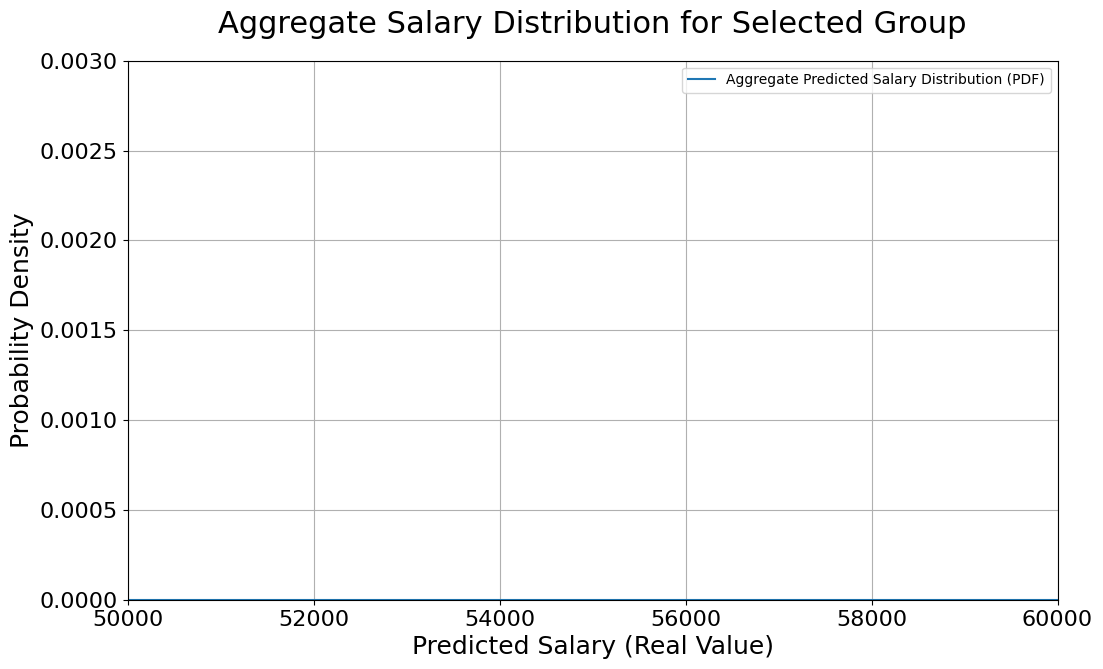

/tmp/ipython-input-148-2816780236.py:181: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


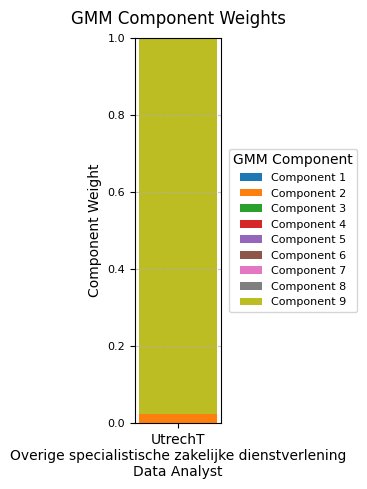

([{'combination': ('UtrechT',
    'Overige specialistische zakelijke dienstverlening',
    'Data Analyst'),
   'predicted_salary': np.float64(115194.57536700176),
   'pi': array([2.2178720e-20, 2.2342736e-02, 1.7763670e-14, 2.8160186e-15,
          2.3455550e-11, 1.9338138e-12, 1.7754655e-05, 6.8433981e-19,
          9.7763956e-01], dtype=float32),
   'mu_log': array([15.54416  , 11.161528 , 11.221985 ,  9.90833  , 11.447894 ,
          11.0540085, 10.510998 , 12.216228 , 11.663229 ], dtype=float32),
   'sigma_log': array([4.90612740e-03, 3.93354828e-03, 6.02847078e+00, 9.06086825e-03,
          3.93354828e-03, 3.93354828e-03, 3.93354828e-03, 3.93354828e-03,
          5.22118403e-03]),
   'weight': np.int64(456)}],
 np.float64(115194.57536700176))

In [151]:
predict_group_distribution(
    model=loaded_model,
    **prediction_parameters)